# Setting

In [1]:
import pandas as pd 
import numpy as np
import datetime # Convert to unix time
import time # Convert to unix time
import os

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #Plots
from matplotlib import rcParams # Size of plots  

plt.rc("font",family="DejaVu Sans")
plt.rc("axes",unicode_minus=False)
plt.style.use("default")

import folium # open street map
import gpxpy.geo # Get the haversine distance
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import cufflinks as cf
import chart_studio.plotly as py

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

import statsmodels.graphics.tsaplots as sgt 

# 1. 데이터 전처리

## (1) npz를 dataframe으로 변환

- week, holi, preholi, min30 데이터 불러오기 (더미변수)

In [2]:
def load_np_data(file_name):
    try:
        load_datasets2=np.load(file_name)
        data_array = np.zeros(load_datasets2['arr_0'].shape)
        data_array = load_datasets2['arr_0']
        print (file_name, 'Loaded')
    except:
        print ('File Load Error! ')
        return -1
        
    return data_array

In [3]:
week = load_np_data('NYC_day_of_week_dataset.npz')
holi = load_np_data('NYC_holiday_dataset.npz')
prevholi = load_np_data('NYC_prev_holiday_dataset.npz')
min30 = load_np_data('NYC_min_30_dataset.npz')

print (week.max(), holi.max(),prevholi.max(), min30.max())
print (week.shape, holi.shape,prevholi.shape, min30.shape)

NYC_day_of_week_dataset.npz Loaded
NYC_holiday_dataset.npz Loaded
NYC_prev_holiday_dataset.npz Loaded
NYC_min_30_dataset.npz Loaded
1.0 1.0 1.0 1.0
(2880, 7) (2880, 1) (2880, 1) (2880, 48)


- train, test 데이터 불러오기

In [4]:
def load_np_data(file_name):    
    try:
        load_datasets2=np.load(file_name)
        data_array = np.zeros(load_datasets2['volume'].shape)
        data_array = load_datasets2['volume']
        print (file_name, 'Loaded')
    except:
        print ('File Load Error! ')
        return -1
        
    return data_array

In [5]:
train_vol = load_np_data('volume_train.npz')
test_vol = load_np_data('volume_test.npz')
total = np.concatenate((train_vol, test_vol), axis=0) 
print (train_vol.max(), test_vol.max(), total.max())
print (train_vol.shape, test_vol.shape, total.shape)

volume_train.npz Loaded
volume_test.npz Loaded
1283.0 1289.0 1289.0
(1920, 10, 20, 2) (960, 10, 20, 2) (2880, 10, 20, 2)


- pickup, dropoff 데이터 구분 및 회전

In [6]:
st_data = total[:, :,:,0]
ed_data = total[:, :,:,1]
print (st_data.max(), ed_data.max())
print (st_data.shape, ed_data.shape)

1149.0 1289.0
(2880, 10, 20) (2880, 10, 20)


In [7]:
# start 270도 회전
st_data_270 = np.empty((2880, 20, 10), int)
for k in range(2880):
    for i in range(10):
        for j in range(20):
            st_data_270[k][j][i] = st_data[k][i][19-j]

In [8]:
# start 270도 회전
ed_data_270 = np.empty((2880, 20, 10), int)
for k in range(2880):
    for i in range(10):
        for j in range(20):
            ed_data_270[k][j][i] = ed_data[k][i][19-j]

In [9]:
print(st_data_270.shape)
print(ed_data_270.shape)

(2880, 20, 10)
(2880, 20, 10)


In [10]:
st_data_new = st_data_270.reshape((st_data_270.shape[0], (st_data_270.shape[1]*st_data_270.shape[2])))
ed_data_new = ed_data_270.reshape((ed_data_270.shape[0], (ed_data_270.shape[1]*ed_data_270.shape[2])))

In [11]:
print(st_data_new.shape , ed_data_new.shape)
print (week.shape, holi.shape,prevholi.shape, min30.shape)

(2880, 200) (2880, 200)
(2880, 7) (2880, 1) (2880, 1) (2880, 48)


- dataframe으로 합치기

In [12]:
st_data_df = pd.DataFrame(st_data_new)
ed_data_df = pd.DataFrame(ed_data_new)
week_df = pd.DataFrame(week)
holi_df = pd.DataFrame(holi)
prevholi_df = pd.DataFrame(prevholi)
min30_df = pd.DataFrame(min30)

In [13]:
vars = np.concatenate([week, holi, prevholi, min30], axis=1)
vars

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [14]:
vars200 = vars
for _ in range(200-1):
    vars200 = np.concatenate([vars200, vars], axis=0)

In [15]:
df_vars200 = pd.DataFrame(vars200)

In [16]:
new1 = pd.DataFrame(np.transpose(st_data_new).reshape((2880*200,1)))

In [17]:
cluster = []
for i in range(200):
    for j in range(2880):
        cluster.append(i)
new1['cluster'] = cluster

In [18]:
df = pd.concat([new1, df_vars200], axis=1)

In [19]:
df.columns = ['Pickup','Clust',
              'Thur','Fri','Sat', 'Sun', 'Mon','Tue','Wed',
              'Holi','PrevHoli','T0','T1','T2',
              'T3','T4','T5','T6','T7',
              'T8','T9','T10','T11','T12',
              'T13','T14','T15','T16','T17',
              'T18','T19','T20','T21','T22',
              'T23','T24','T25','T26','T27',
              'T28','T29','T30','T31','T32',
              'T33','T34','T35','T36','T37',
              'T38','T39','T40','T41','T42',
              'T43','T44','T45','T46','T47']

In [20]:
new2 = pd.DataFrame(np.transpose(ed_data_new).reshape((2880*200,1)))
new2.columns = ['Dropoff']

In [21]:
df = pd.concat([df, new2], axis=1)

In [22]:
df[df['Clust']==190] # 회전이 제대로 되었는지 확인

,Pickup,Clust,Thur,Fri,Sat,Sun,Mon,Tue,Wed,Holi,...,T39,T40,T41,T42,T43,T44,T45,T46,T47,Dropoff
547200,64,190,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39
547201,88,190,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108
547202,102,190,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129
547203,96,190,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107
547204,69,190,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550075,20,190,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,37
550076,21,190,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,47
550077,18,190,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36
550078,9,190,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,33


## (2) train, test 구분하기

In [23]:
train = pd.DataFrame()
for i in range(200):
    train = pd.concat([train, df.iloc[2880*i:2880*i+1920, :]], axis=0)

In [24]:
train.shape # 40days * 48times * 200clusters

(384000, 60)

In [25]:
test = pd.DataFrame()
for i in range(200):
    test = pd.concat([test, df.iloc[2880*i+1920:2880*(i+1), :]], axis=0)

In [26]:
test.shape # 20days * 48times * 200clusters

(192000, 60)

## (3) lag 변수 추가하기

- train

In [27]:
# Pickup lag 만들기 (8개)
train['p_lag1'] = train.groupby('Clust').shift(1)['Pickup']
train['p_lag2'] = train.groupby('Clust').shift(2)['Pickup']
train['p_lag3'] = train.groupby('Clust').shift(3)['Pickup']
train['p_lag4'] = train.groupby('Clust').shift(4)['Pickup']
train['p_lag5'] = train.groupby('Clust').shift(5)['Pickup']
train['p_lag6'] = train.groupby('Clust').shift(6)['Pickup']
train['p_lag7'] = train.groupby('Clust').shift(7)['Pickup']
train['p_lag8'] = train.groupby('Clust').shift(8)['Pickup']

In [28]:
# Dropoff lag 만들기 (16개)
train['d_lag1'] = train.groupby('Clust').shift(1)['Dropoff']
train['d_lag2'] = train.groupby('Clust').shift(2)['Dropoff']
train['d_lag3'] = train.groupby('Clust').shift(3)['Dropoff']
train['d_lag4'] = train.groupby('Clust').shift(4)['Dropoff']
train['d_lag5'] = train.groupby('Clust').shift(5)['Dropoff']
train['d_lag6'] = train.groupby('Clust').shift(6)['Dropoff']
train['d_lag7'] = train.groupby('Clust').shift(7)['Dropoff']
train['d_lag8'] = train.groupby('Clust').shift(8)['Dropoff']
train['d_lag9'] = train.groupby('Clust').shift(9)['Dropoff']
train['d_lag10'] = train.groupby('Clust').shift(10)['Dropoff']
train['d_lag11'] = train.groupby('Clust').shift(11)['Dropoff']
train['d_lag12'] = train.groupby('Clust').shift(12)['Dropoff']
train['d_lag13'] = train.groupby('Clust').shift(13)['Dropoff']
train['d_lag14'] = train.groupby('Clust').shift(14)['Dropoff']
train['d_lag15'] = train.groupby('Clust').shift(15)['Dropoff']
train['d_lag16'] = train.groupby('Clust').shift(16)['Dropoff']

In [29]:
train = train.dropna()

In [30]:
# 384000-16*200 = 380800
# 57 + 1 + (1 + 8) + (1 + 16)
train.shape

(380800, 84)

- test

In [31]:
# Pickup lag 만들기 (8개)
test['p_lag1'] = test.groupby('Clust').shift(1)['Pickup']
test['p_lag2'] = test.groupby('Clust').shift(2)['Pickup']
test['p_lag3'] = test.groupby('Clust').shift(3)['Pickup']
test['p_lag4'] = test.groupby('Clust').shift(4)['Pickup']
test['p_lag5'] = test.groupby('Clust').shift(5)['Pickup']
test['p_lag6'] = test.groupby('Clust').shift(6)['Pickup']
test['p_lag7'] = test.groupby('Clust').shift(7)['Pickup']
test['p_lag8'] = test.groupby('Clust').shift(8)['Pickup']

In [32]:
# Dropoff lag 만들기 (16개)
test['d_lag1'] = test.groupby('Clust').shift(1)['Dropoff']
test['d_lag2'] = test.groupby('Clust').shift(2)['Dropoff']
test['d_lag3'] = test.groupby('Clust').shift(3)['Dropoff']
test['d_lag4'] = test.groupby('Clust').shift(4)['Dropoff']
test['d_lag5'] = test.groupby('Clust').shift(5)['Dropoff']
test['d_lag6'] = test.groupby('Clust').shift(6)['Dropoff']
test['d_lag7'] = test.groupby('Clust').shift(7)['Dropoff']
test['d_lag8'] = test.groupby('Clust').shift(8)['Dropoff']
test['d_lag9'] = test.groupby('Clust').shift(9)['Dropoff']
test['d_lag10'] = test.groupby('Clust').shift(10)['Dropoff']
test['d_lag11'] = test.groupby('Clust').shift(11)['Dropoff']
test['d_lag12'] = test.groupby('Clust').shift(12)['Dropoff']
test['d_lag13'] = test.groupby('Clust').shift(13)['Dropoff']
test['d_lag14'] = test.groupby('Clust').shift(14)['Dropoff']
test['d_lag15'] = test.groupby('Clust').shift(15)['Dropoff']
test['d_lag16'] = test.groupby('Clust').shift(16)['Dropoff']

In [33]:
test = test.dropna()

In [34]:
# 192000-16*200 = 188800
# 57 + 1 + (1 + 8) + (1 + 16)
test.shape

(188800, 84)

# 2. EDA

## (0) 지도 표현

In [35]:
jan = pd.read_csv("jan.csv")

In [36]:
feb = pd.read_csv("feb.csv")

In [37]:
map_train = pd.concat([jan, feb], axis=0).drop(['trip_distance', 'total_amount', 'passenger_count', 'RateCodeID',
                                               'store_and_fwd_flag', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
                                               'tolls_amount', 'vendor_id', 'rate_code', 'payment_type', 'imp_surcharge'], axis=1)

In [38]:
map_train = map_train[(map_train['pickup_datetime'] < '2015-02-10 00:00:00')]

- 분석에 이용할 지역을 지도 위에 표시

In [39]:
# removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -73.996317) & (new_frame.dropoff_longitude <= -73.96834326) &\
                       (new_frame.dropoff_latitude >= 40.68132125) & (new_frame.dropoff_latitude <= 40.81703286)) & \
                       ((new_frame.pickup_longitude >= -73.996317) & (new_frame.pickup_longitude <= -73.96834326)& \
                       (new_frame.pickup_latitude >= 40.68132125) & (new_frame.pickup_latitude <= 40.81703286))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -73.996317) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.68132125) & (new_frame.dropoff_latitude <= 40.81703286)) & \
                       ((new_frame.pickup_longitude >= -73.996317) & (new_frame.pickup_longitude <= -73.96834326)& \
                       (new_frame.pickup_latitude >= 40.68132125) & (new_frame.pickup_latitude <= 40.81703286))]

    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [40]:
map_train_ny = remove_outliers(map_train)

Number of pickup records =  25183422
Number of outlier coordinates lying outside NY boundaries: 16830276
Total outliers removed 13887620
---


In [41]:
map_osm = folium.Map(location=[40.734695, -73.990372])

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = map_train_ny.head(500)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)

map_osm

## (0) Pixel Visualization

In [42]:
day = 5 ; idx_list = [] ; time_list = []
# for t in range(0,24,6):
for t in [3,7,15,19]:   
    time_list.append(str(t))
    idx_list.append(48*(day-1) + (t-1)*2)

print(time_list) ; print(idx_list)

['3', '7', '15', '19']
[196, 204, 220, 228]


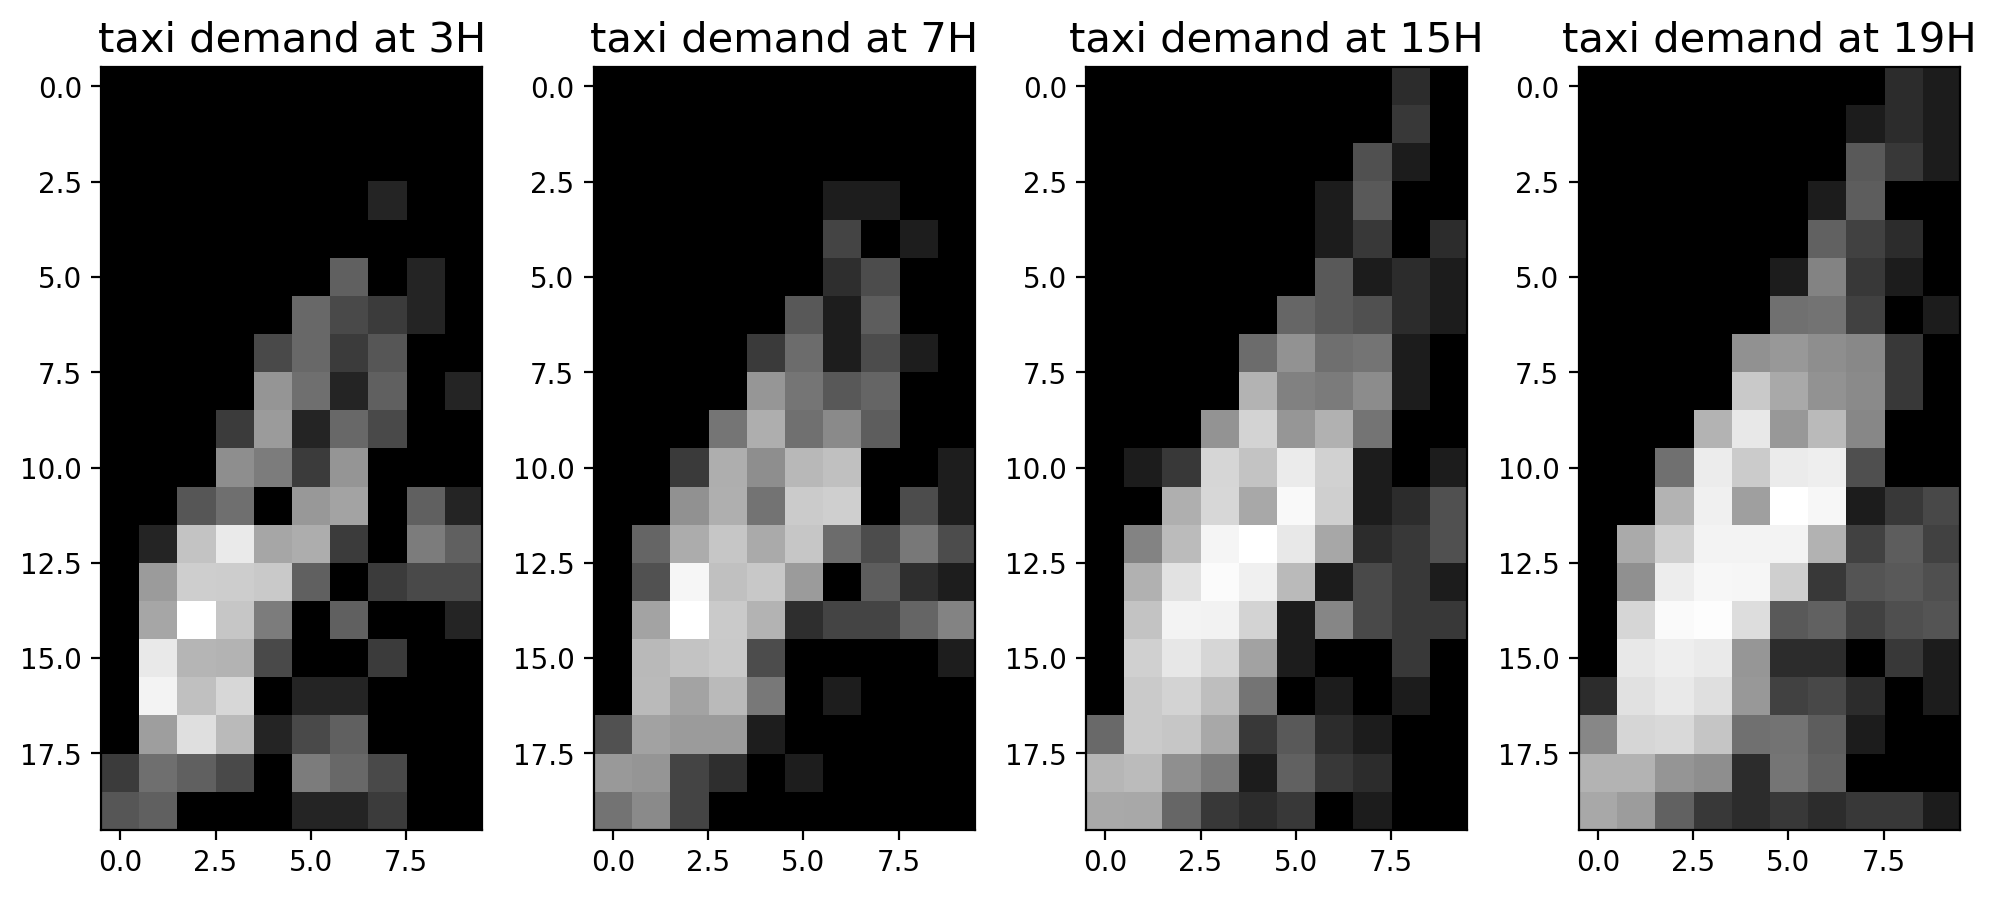

In [43]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(10, 20))
idx1 = idx_list[0]
ax1.imshow(np.log(st_data_270[idx1, :, :]+1), cmap='gray')
ax1.set_title(f"taxi demand at {time_list[0]}H", fontsize=15)

idx2 = idx_list[1]
ax2.imshow(np.log(st_data_270[idx2, :, :]+1), cmap='gray')
ax2.set_title(f"taxi demand at {time_list[1]}H", fontsize=15)

idx3 = idx_list[2]
ax3.imshow(np.log(ed_data_270[idx3, :, :]+1), cmap='gray')
ax3.set_title(f"taxi demand at {time_list[2]}H", fontsize=15)

idx4 =idx_list[3]
ax4.imshow(np.log(ed_data_270[idx4, :, :]+1), cmap='gray')
ax4.set_title(f"taxi demand at {time_list[3]}H", fontsize=15)

plt.gca().set_facecolor('white')
f.tight_layout()

## (1) 연속형 변수에 대한 기술 통계량 및 Boxplot

- EDA를 위하여 datetime 변수 추가하기

In [44]:
date_list = []
lis = pd.date_range(start="2015-01-02",end="2015-02-09")
for i in range(32):
    a = pd.to_datetime("2015-01-01", format="%Y-%m-%d")
    date_list.append(a)
for j in lis:
    for k in range(48):
        date_list.append(j)
date_list = date_list*200

In [45]:
date_list = pd.DataFrame([date_obj.strftime('%Y-%m-%d') for date_obj in date_list])
date_list.columns = ['datetime']

In [46]:
date_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380800 entries, 0 to 380799
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   datetime  380800 non-null  object
dtypes: object(1)
memory usage: 2.9+ MB


In [47]:
eda_train = train[['Pickup', 'Clust', 'Thur', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed',
                   'Holi', 'PrevHoli', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7',
                   'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17',
                   'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27',
                   'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37',
                   'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47',
                   'Dropoff']].reset_index().drop('index', axis=1)

In [48]:
eda_train = pd.concat([date_list, eda_train], axis=1)
eda_train['datetime'] = pd.to_datetime(eda_train['datetime'], format="%Y-%m-%d")

In [49]:
day = eda_train[['datetime', 'Pickup', 'Dropoff']].groupby(pd.Grouper(key='datetime', freq='D')).mean().reset_index()

In [50]:
holi = day[(day['datetime'] == '2015-01-01') | (day['datetime'] == '2015-01-19')]
prevholi = day[day['datetime'] == '2015-01-18']

In [51]:
train[['Pickup','Dropoff']].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
Pickup,380800.0,37.770919,106.091875,0.0,0.0,0.0,9.0,118.0,262.0,547.0,825.201,1149.0
Dropoff,380800.0,37.768566,98.320643,0.0,0.0,2.0,17.0,115.0,250.0,496.0,771.201,1283.0


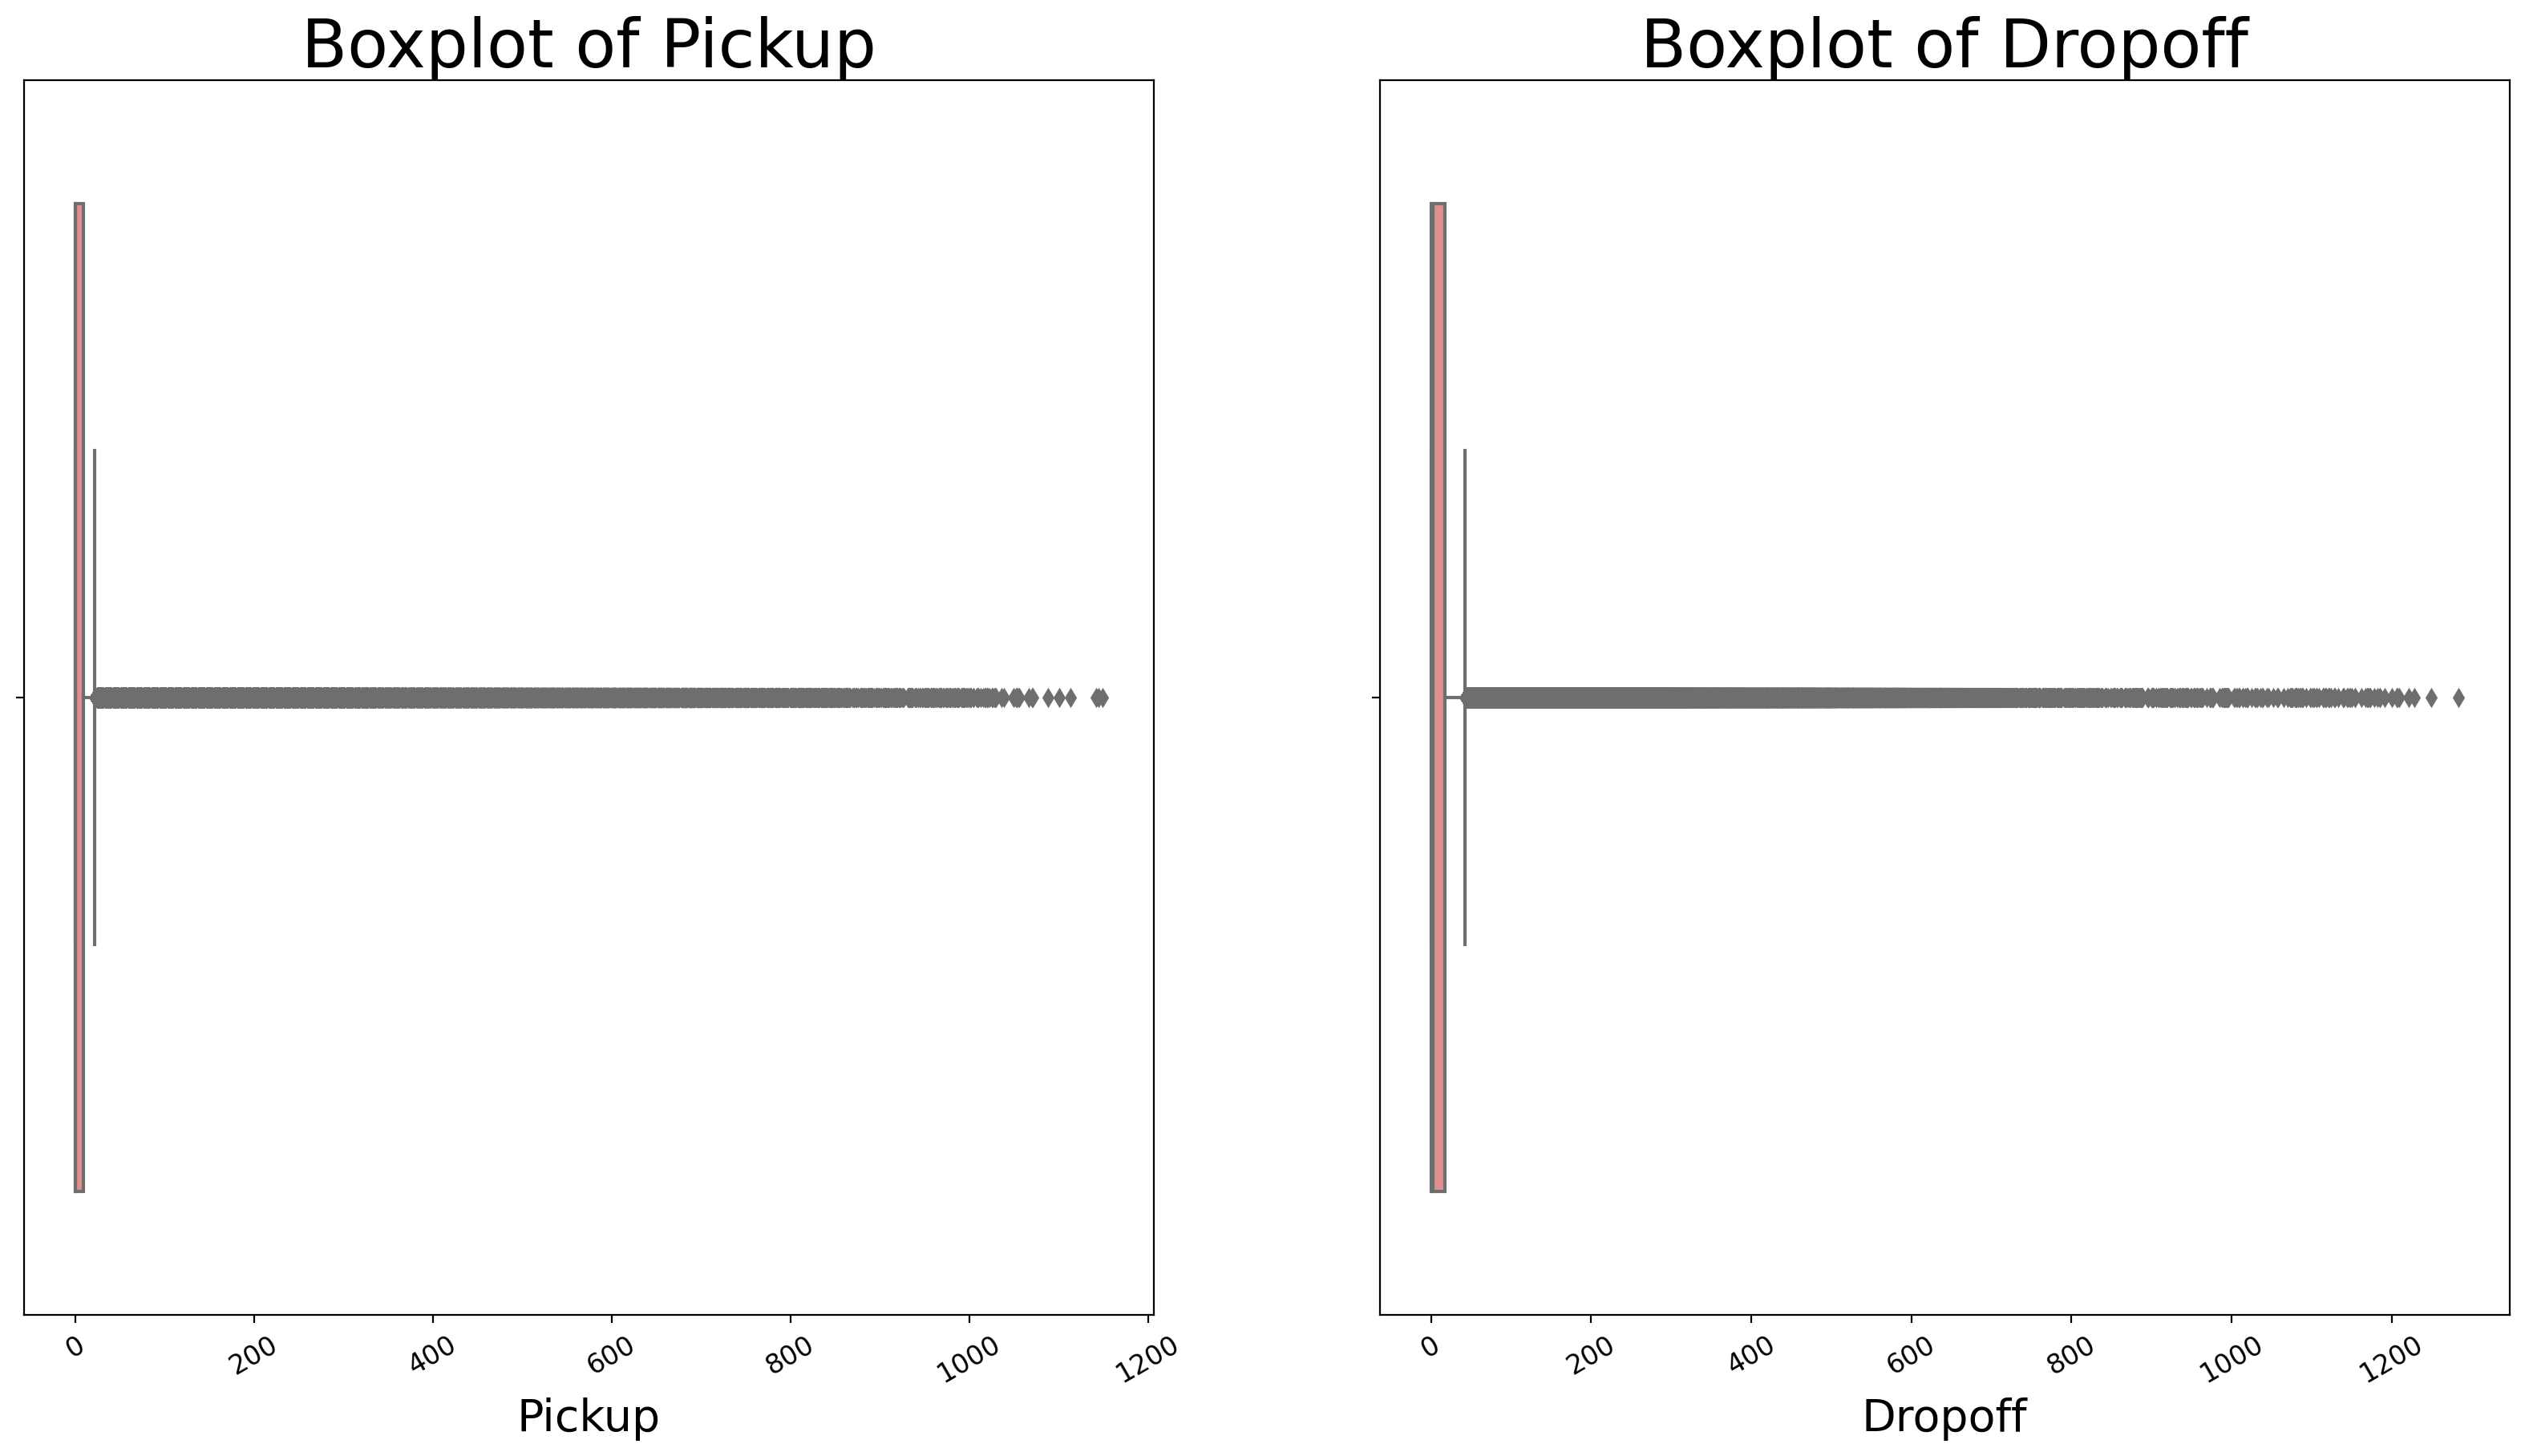

In [52]:
obj = ['Pickup','Dropoff']

fig = plt.figure(figsize=(20,10))
for i in range(2):
    sns.boxplot(data=train, x=obj[i], color='lightcoral', ax=plt.subplot(1, 2, i+1))
    plt.xticks(rotation=30, fontsize=12)
    plt.xlabel(obj[i], fontsize=20)
    plt.title("Boxplot of "+obj[i], fontsize = 30);

## (2) Pickup을 lag8까지 보는 이유: ACF plot

In [53]:
lis = pd.date_range(start="2015-01-01 08:00:00",end="2015-02-09 23:30:00", freq='30min') 
lis = [date_obj.strftime('%Y-%m-%d %H:%M:%S') for date_obj in lis] * 200
lis = pd.DataFrame(lis)
lis.shape

(380800, 1)

In [54]:
lis.columns = ['datetime2']
eda_train2 = pd.concat([eda_train, lis], axis=1)

In [55]:
eda_train2['datetime2'] = pd.to_datetime(eda_train2['datetime2'])

In [56]:
df_acf = eda_train2[['datetime2', 'Pickup', 'Dropoff']].groupby([pd.Grouper(key='datetime2', freq='30min')]).sum().reset_index()

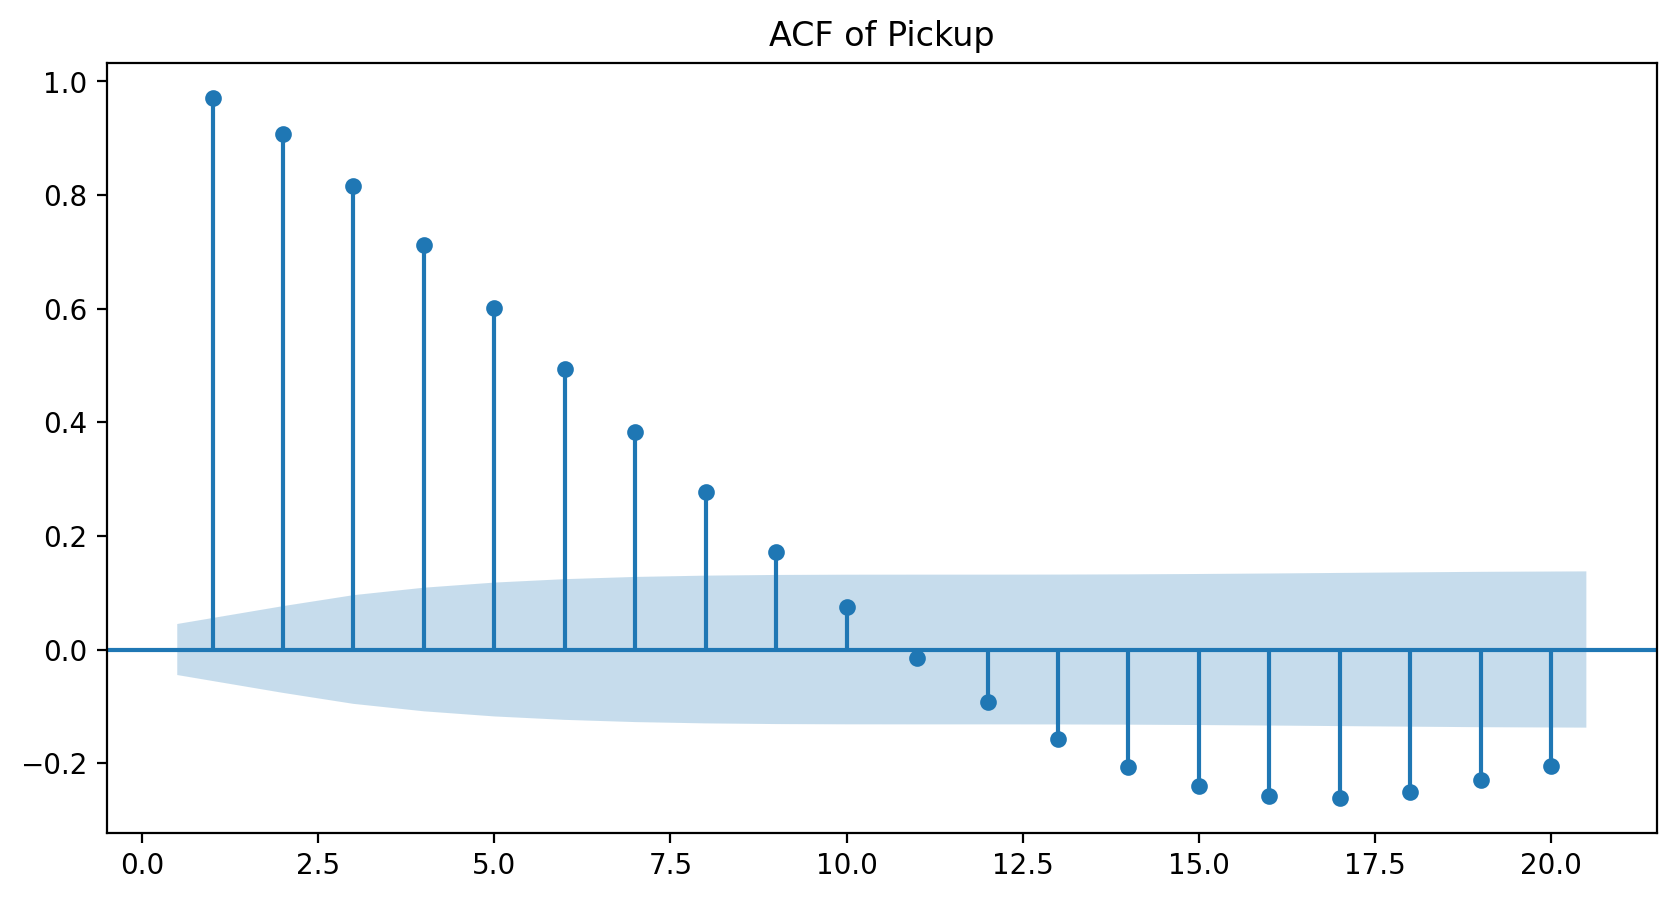

In [57]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)

sgt.plot_acf(df_acf['Pickup'], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF of Pickup")

plt.show()

## (3) 한 지역(190번째 지역)의 일주일간 시간 별 승차 건수

In [58]:
cls190 = eda_train2[(eda_train2['Clust'] == 190) &
                   (eda_train2['datetime'] >= '2015-01-10 00:00:00') &
                   (eda_train2['datetime'] < '2015-01-17 00:00:00')].reset_index().drop('index', axis=1)

In [59]:
lis = pd.date_range(start="2015-01-10 00:00", end="2015-01-16 23:30", freq='12H')
lis = [date_obj.strftime('%Y-%m-%d %H:%M') for date_obj in lis]

In [60]:
cls190['datetime2'] = pd.to_datetime(cls190['datetime2']).apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))

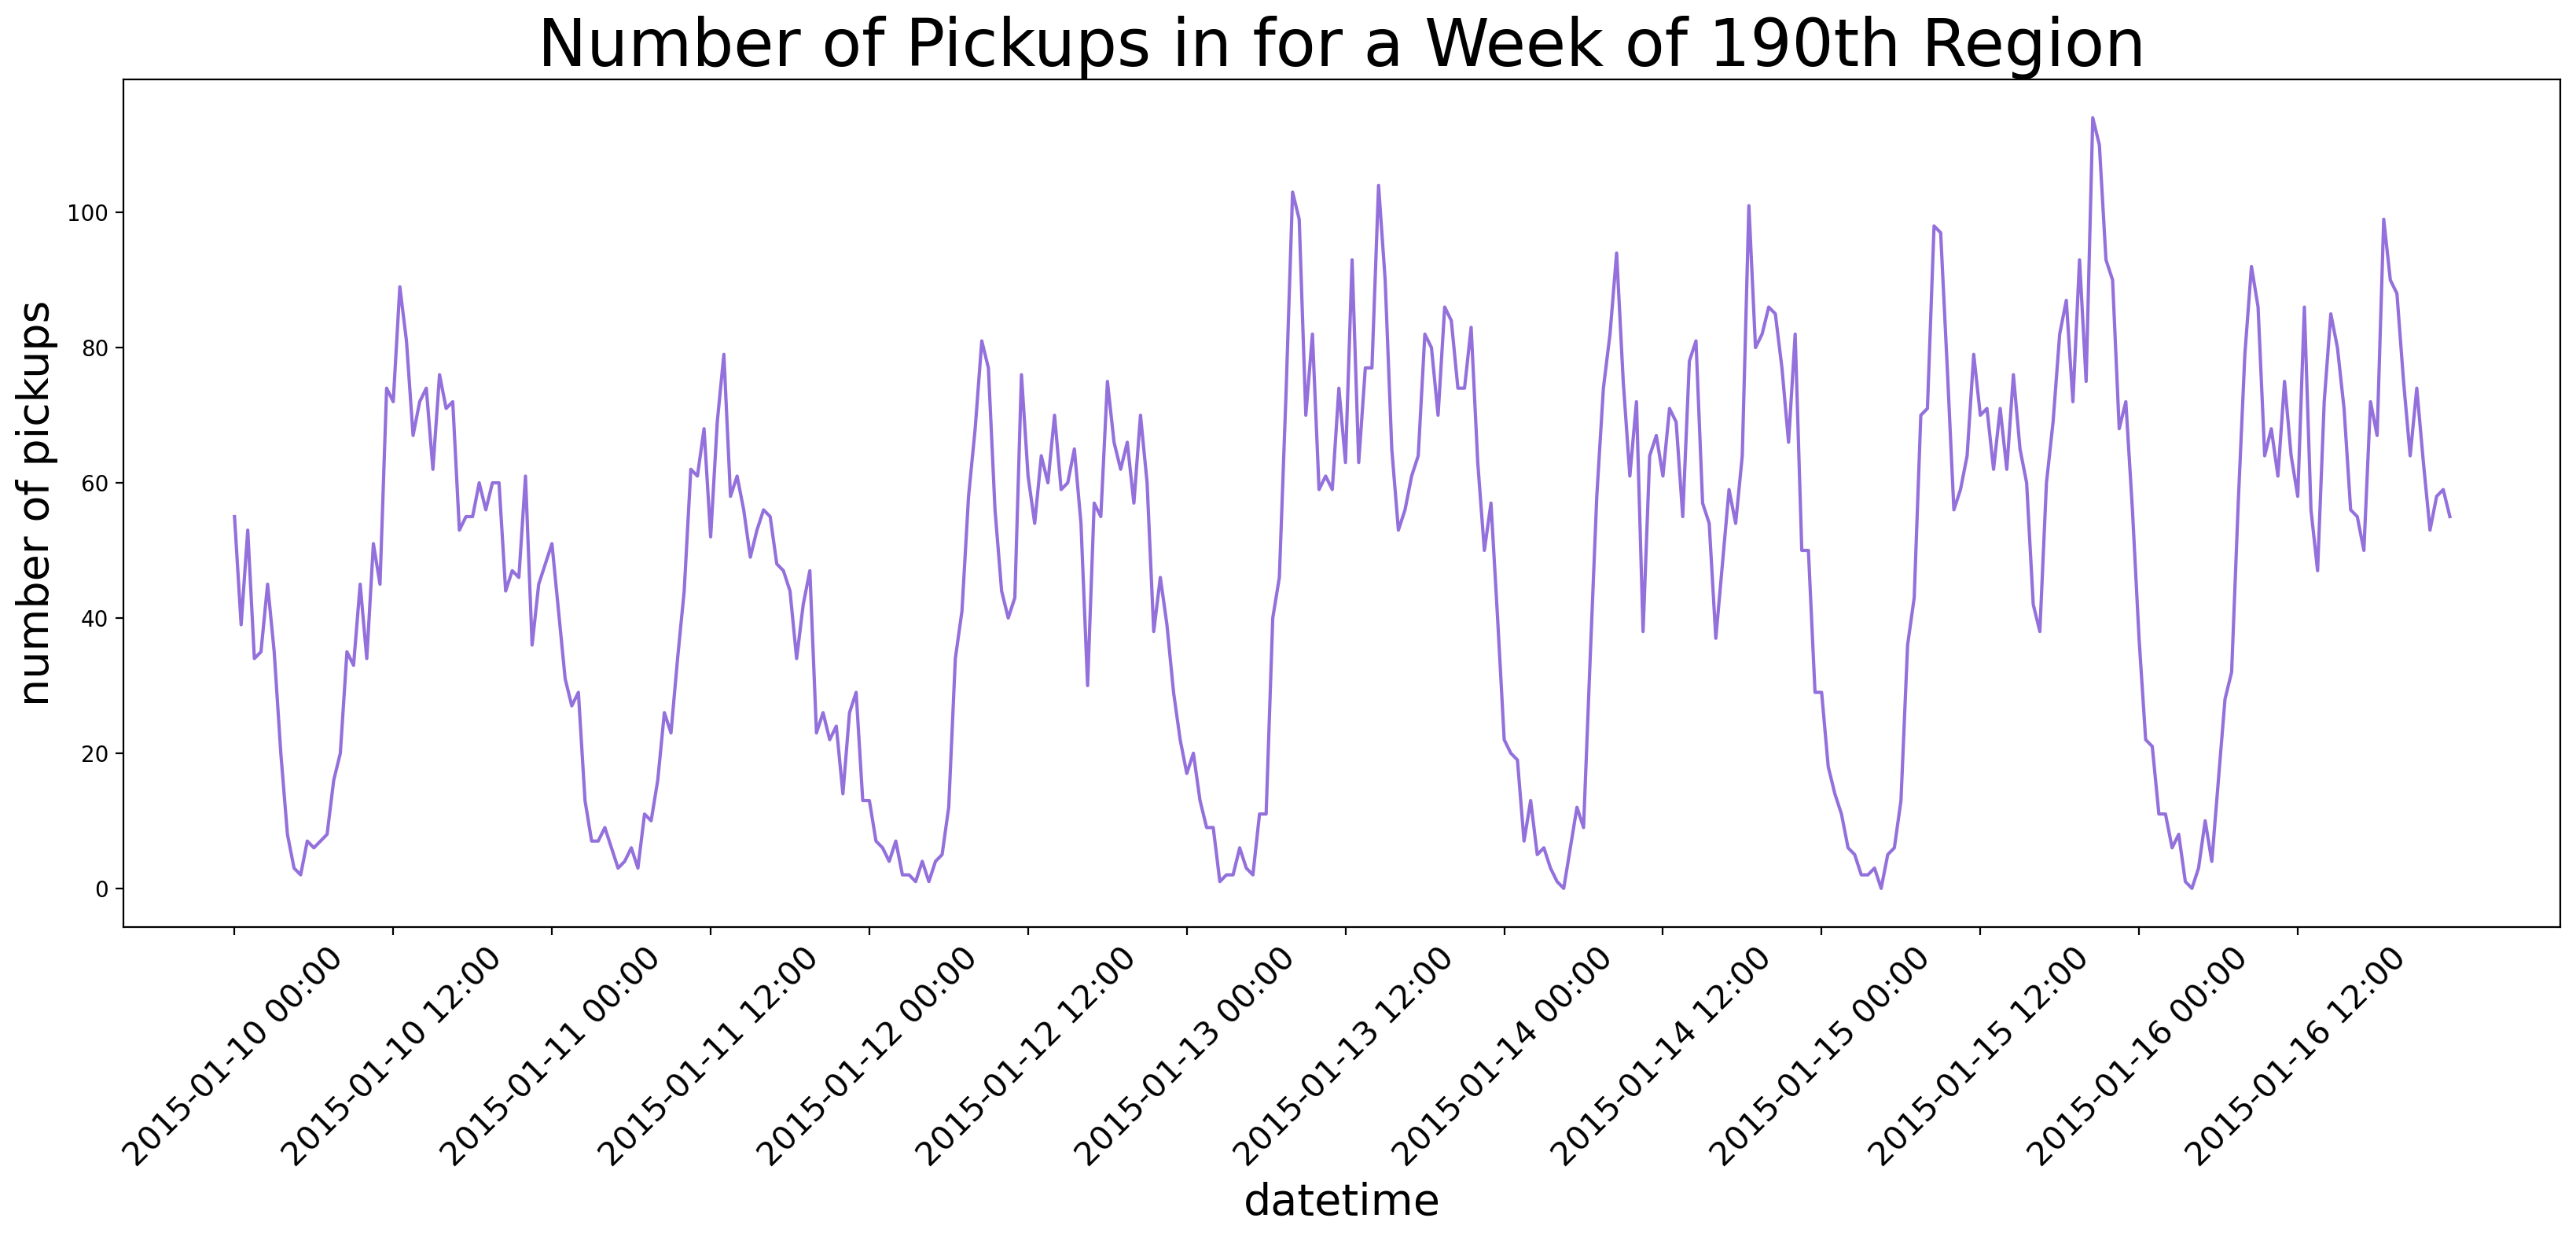

In [61]:
plt.figure(figsize=(20,7))
plt.plot(cls190['datetime2'], cls190['Pickup'], color='mediumpurple')
plt.xticks(rotation=45, fontsize=15)
plt.xticks(lis)
plt.title('Number of Pickups in for a Week of 190th Region', fontdict = {'fontsize' : 30})
plt.xlabel('datetime', fontdict = {'fontsize' : 20})
plt.ylabel('number of pickups', fontdict = {'fontsize' : 20})
plt.show()

## (4) 일별 평균 승차 건수 

Text(0.5, 1.0, 'Number of Pickups by Day')

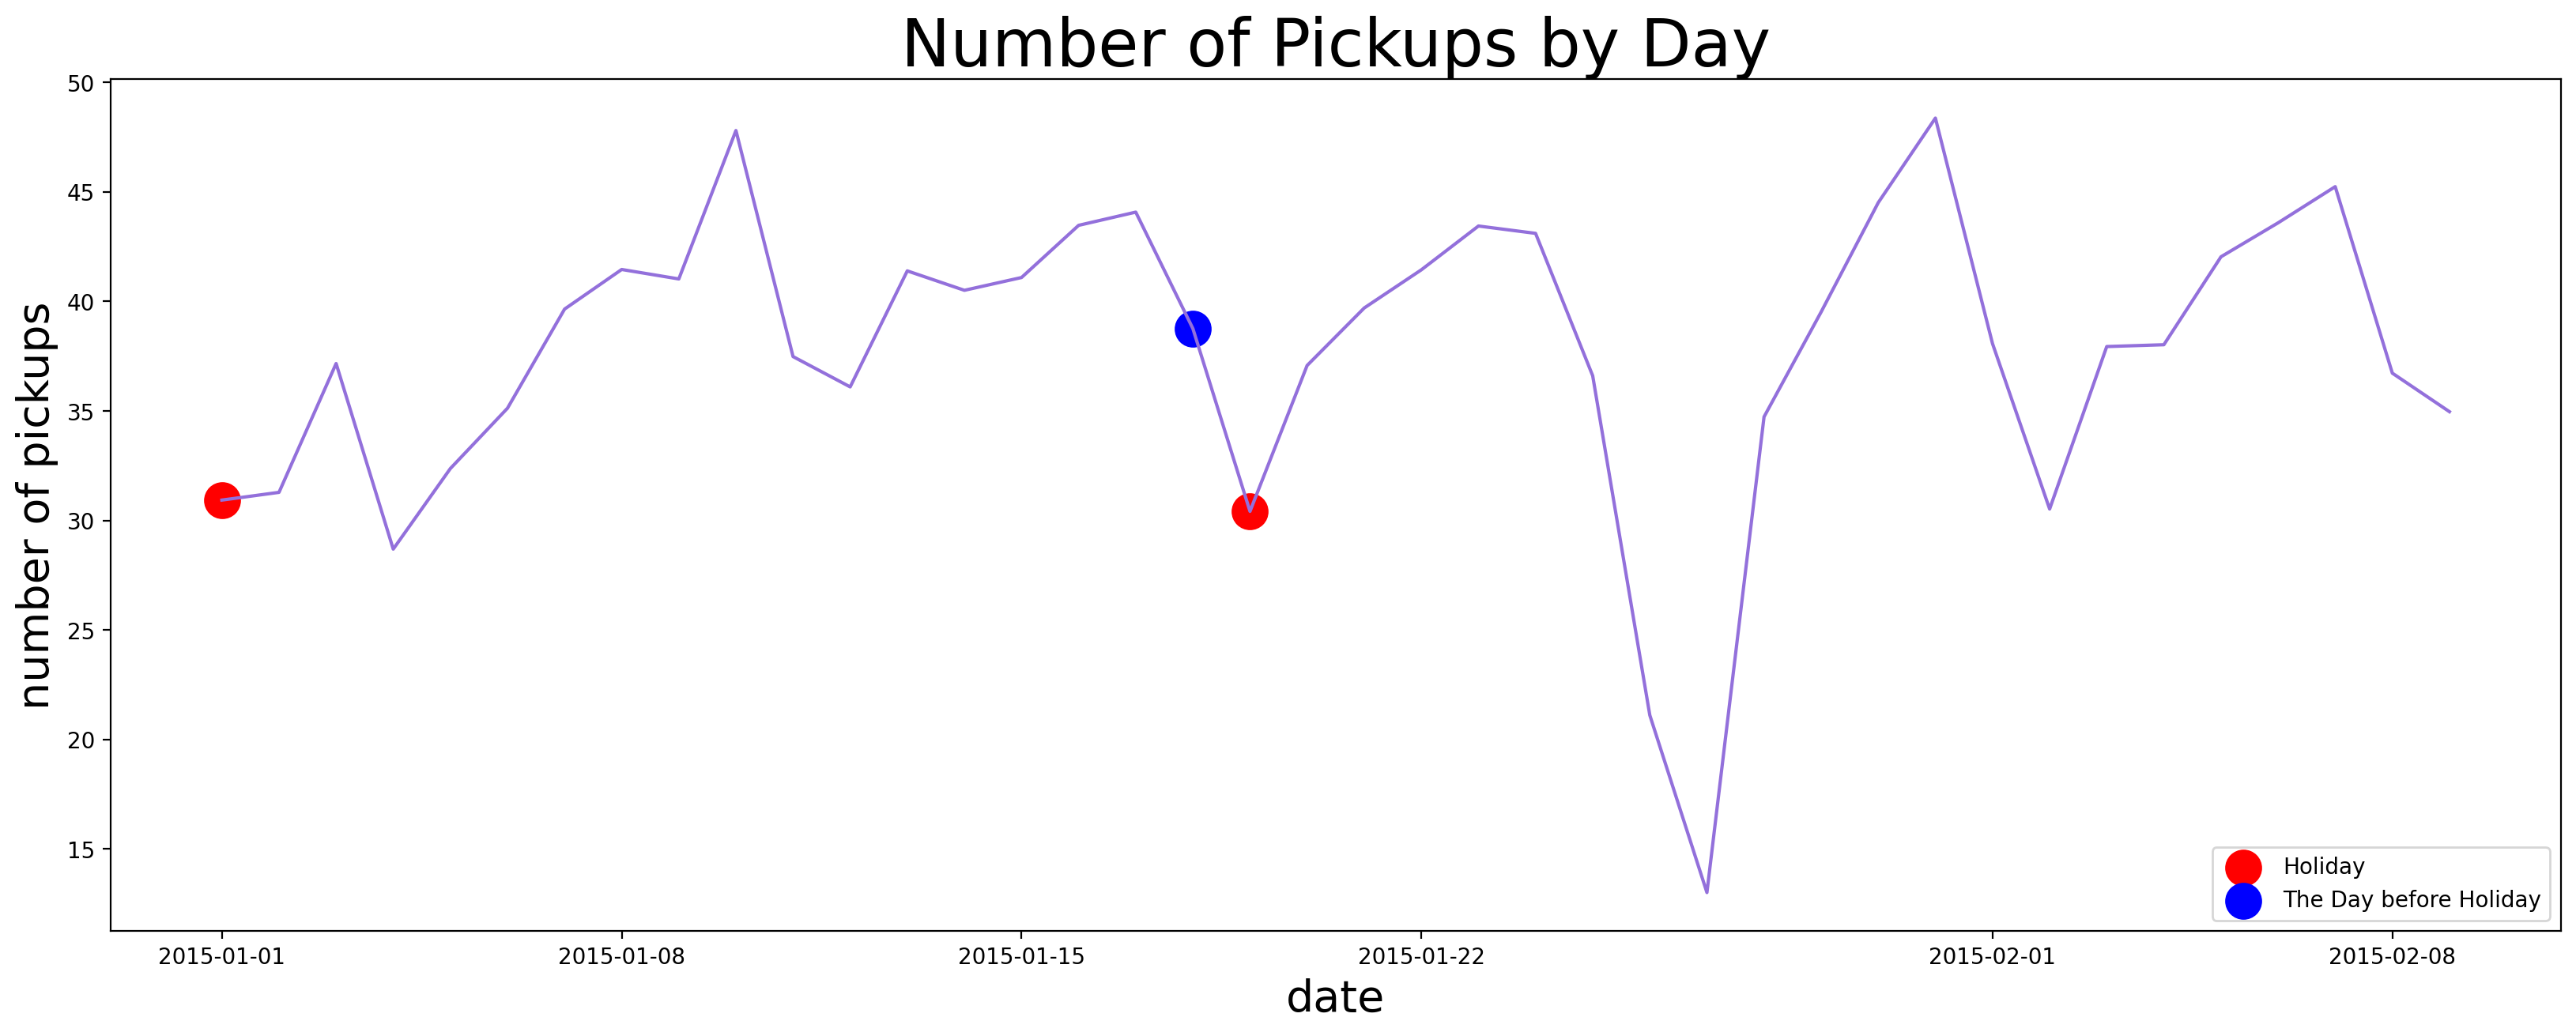

In [62]:
plt.figure(figsize=(20,7))
plt.plot(day["datetime"], day["Pickup"], color='mediumpurple')
plt.scatter(holi['datetime'][0], holi['Pickup'][0], color='red', s=250, label = 'Holiday')
plt.scatter(holi['datetime'][18], holi['Pickup'][18], color='red', s=250)
plt.scatter(prevholi['datetime'][17], prevholi['Pickup'][17], color='blue', s=250, label = 'The Day before Holiday')
plt.legend(loc='lower right')
plt.xlabel('date', fontdict={'fontsize':20})
plt.ylabel('number of pickups', fontdict={'fontsize':20})
plt.title('Number of Pickups by Day', fontdict={'fontsize':30})

In [63]:
day[day['Pickup'] == 13.0096875]

,datetime,Pickup,Dropoff
26,2015-01-27,13.009688,12.930104


In [64]:
day[day['Dropoff'] == 12.930104166666666]

,datetime,Pickup,Dropoff
26,2015-01-27,13.009688,12.930104


## (5) 요일별 평균 승차 건수

In [65]:
dayofweek1 = eda_train[['datetime', 'Thur', 'Fri', 'Sat', 'Sun', 'Mon','Tue', 'Wed']].groupby(pd.Grouper(key='datetime', freq='D')).mean().reset_index()

In [66]:
dayofweek = pd.merge(day, dayofweek1, left_on='datetime', right_on='datetime', how='inner')

In [67]:
dayofweek['dayofweek'] = 0
for i in range(len(dayofweek)):
    if dayofweek.iloc[i, 3] == 1:
        dayofweek.iloc[i, 10] = 'Thursday'
    elif dayofweek.iloc[i, 4] == 1:
        dayofweek.iloc[i, 10] = 'Friday'
    elif dayofweek.iloc[i, 5] == 1:
        dayofweek.iloc[i, 10] = 'Saturday'
    elif dayofweek.iloc[i, 6] == 1:
        dayofweek.iloc[i, 10] = 'Sunday'
    elif dayofweek.iloc[i, 7] == 1:
        dayofweek.iloc[i, 10] = 'Monday'
    elif dayofweek.iloc[i, 8] == 1:
        dayofweek.iloc[i, 10] = 'Tuesday'
    elif dayofweek.iloc[i, 9] == 1:
        dayofweek.iloc[i, 10] = 'Wednesday'

In [68]:
Thursday = dayofweek[dayofweek['dayofweek'] == 'Thursday']
Friday = dayofweek[dayofweek['dayofweek'] == 'Friday']
Saturday = dayofweek[dayofweek['dayofweek'] == 'Saturday']
Sunday = dayofweek[dayofweek['dayofweek'] == 'Sunday']
Monday = dayofweek[dayofweek['dayofweek'] == 'Monday']
Tuesday = dayofweek[dayofweek['dayofweek'] == 'Tuesday']
Wednesday = dayofweek[dayofweek['dayofweek'] == 'Wednesday']

Text(0.5, 1.0, 'Number of Pickups by Day of the Week')

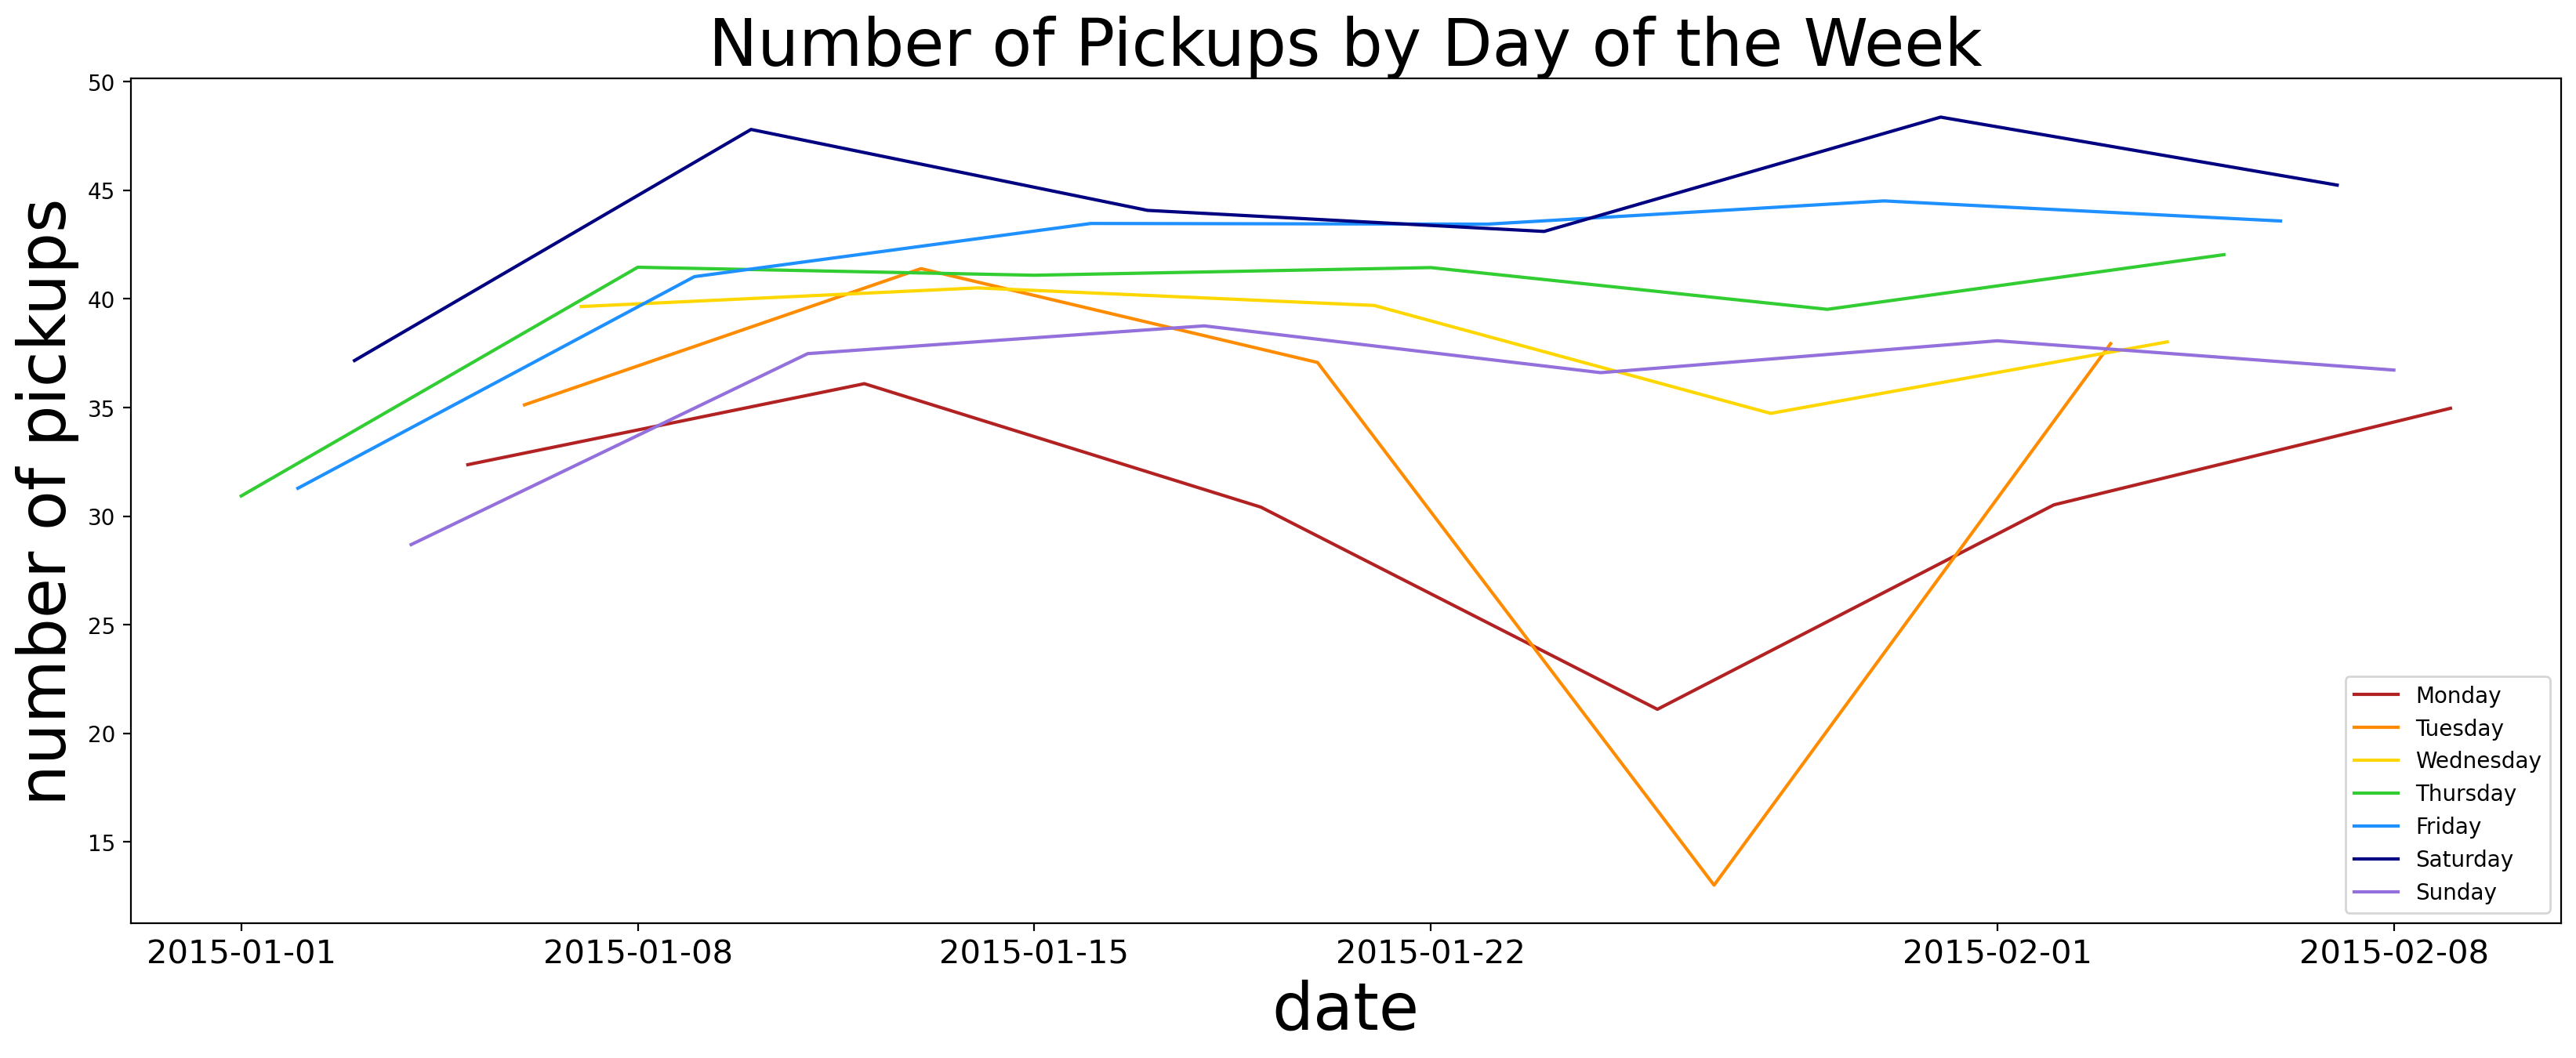

In [69]:
plt.figure(figsize=(20,7))
plt.plot(Monday["datetime"], Monday["Pickup"], color='firebrick', label='Monday')
plt.plot(Tuesday["datetime"], Tuesday["Pickup"], color='darkorange', label='Tuesday')
plt.plot(Wednesday["datetime"], Wednesday["Pickup"], color='gold', label='Wednesday')
plt.plot(Thursday["datetime"], Thursday["Pickup"], color='limegreen', label='Thursday')
plt.plot(Friday["datetime"], Friday["Pickup"], color='dodgerblue', label='Friday')
plt.plot(Saturday["datetime"], Saturday["Pickup"], color='navy', label='Saturday')
plt.plot(Sunday["datetime"], Sunday["Pickup"], color='mediumpurple', label='Sunday')
plt.xticks(fontsize=15)
plt.legend(loc='lower right')
plt.xlabel('date', fontdict={'fontsize':30})
plt.ylabel('number of pickups', fontdict={'fontsize':30})
plt.title('Number of Pickups by Day of the Week', fontdict={'fontsize':30})

## (6) 하루동안 지역 간 승차 건수 비교 (거주지역 VS 금융지구)

In [70]:
eda_train2['datetime2'] = pd.DataFrame([date_obj.strftime('%Y-%m-%d %H:%M:%S') for date_obj in eda_train2.iloc[:, 61]])

In [71]:
cls142_0115 = eda_train2[(eda_train2['Clust'] == 142) & (eda_train2['datetime'] == '2015-01-15')].reset_index().drop('index', axis=1)
cls142_0119 = eda_train2[(eda_train2['Clust'] == 142) & (eda_train2['datetime'] == '2015-01-19')].reset_index().drop('index', axis=1)

In [72]:
cls142_0115['datetime3'] = 0
for i in range(len(cls142_0115)):
    cls142_0115.iloc[i, 62] = cls142_0115.iloc[i, 61][-8:-3]
cls142_0119['datetime3'] = 0
for i in range(len(cls142_0119)):
    cls142_0119.iloc[i, 62] = cls142_0119.iloc[i, 61][-8:-3]

In [73]:
cls97_0115 = eda_train2[(eda_train2['Clust'] == 97) & (eda_train2['datetime'] == '2015-01-15')].reset_index().drop('index', axis=1)
cls97_0119 = eda_train2[(eda_train2['Clust'] == 97) & (eda_train2['datetime'] == '2015-01-19')].reset_index().drop('index', axis=1)

In [74]:
cls97_0115['datetime3'] = 0
for i in range(len(cls97_0115)):
    cls97_0115.iloc[i, 62] = cls97_0115.iloc[i, 61][-8:-3]
cls97_0119['datetime3'] = 0
for i in range(len(cls97_0119)):
    cls97_0119.iloc[i, 62] = cls97_0119.iloc[i, 61][-8:-3]

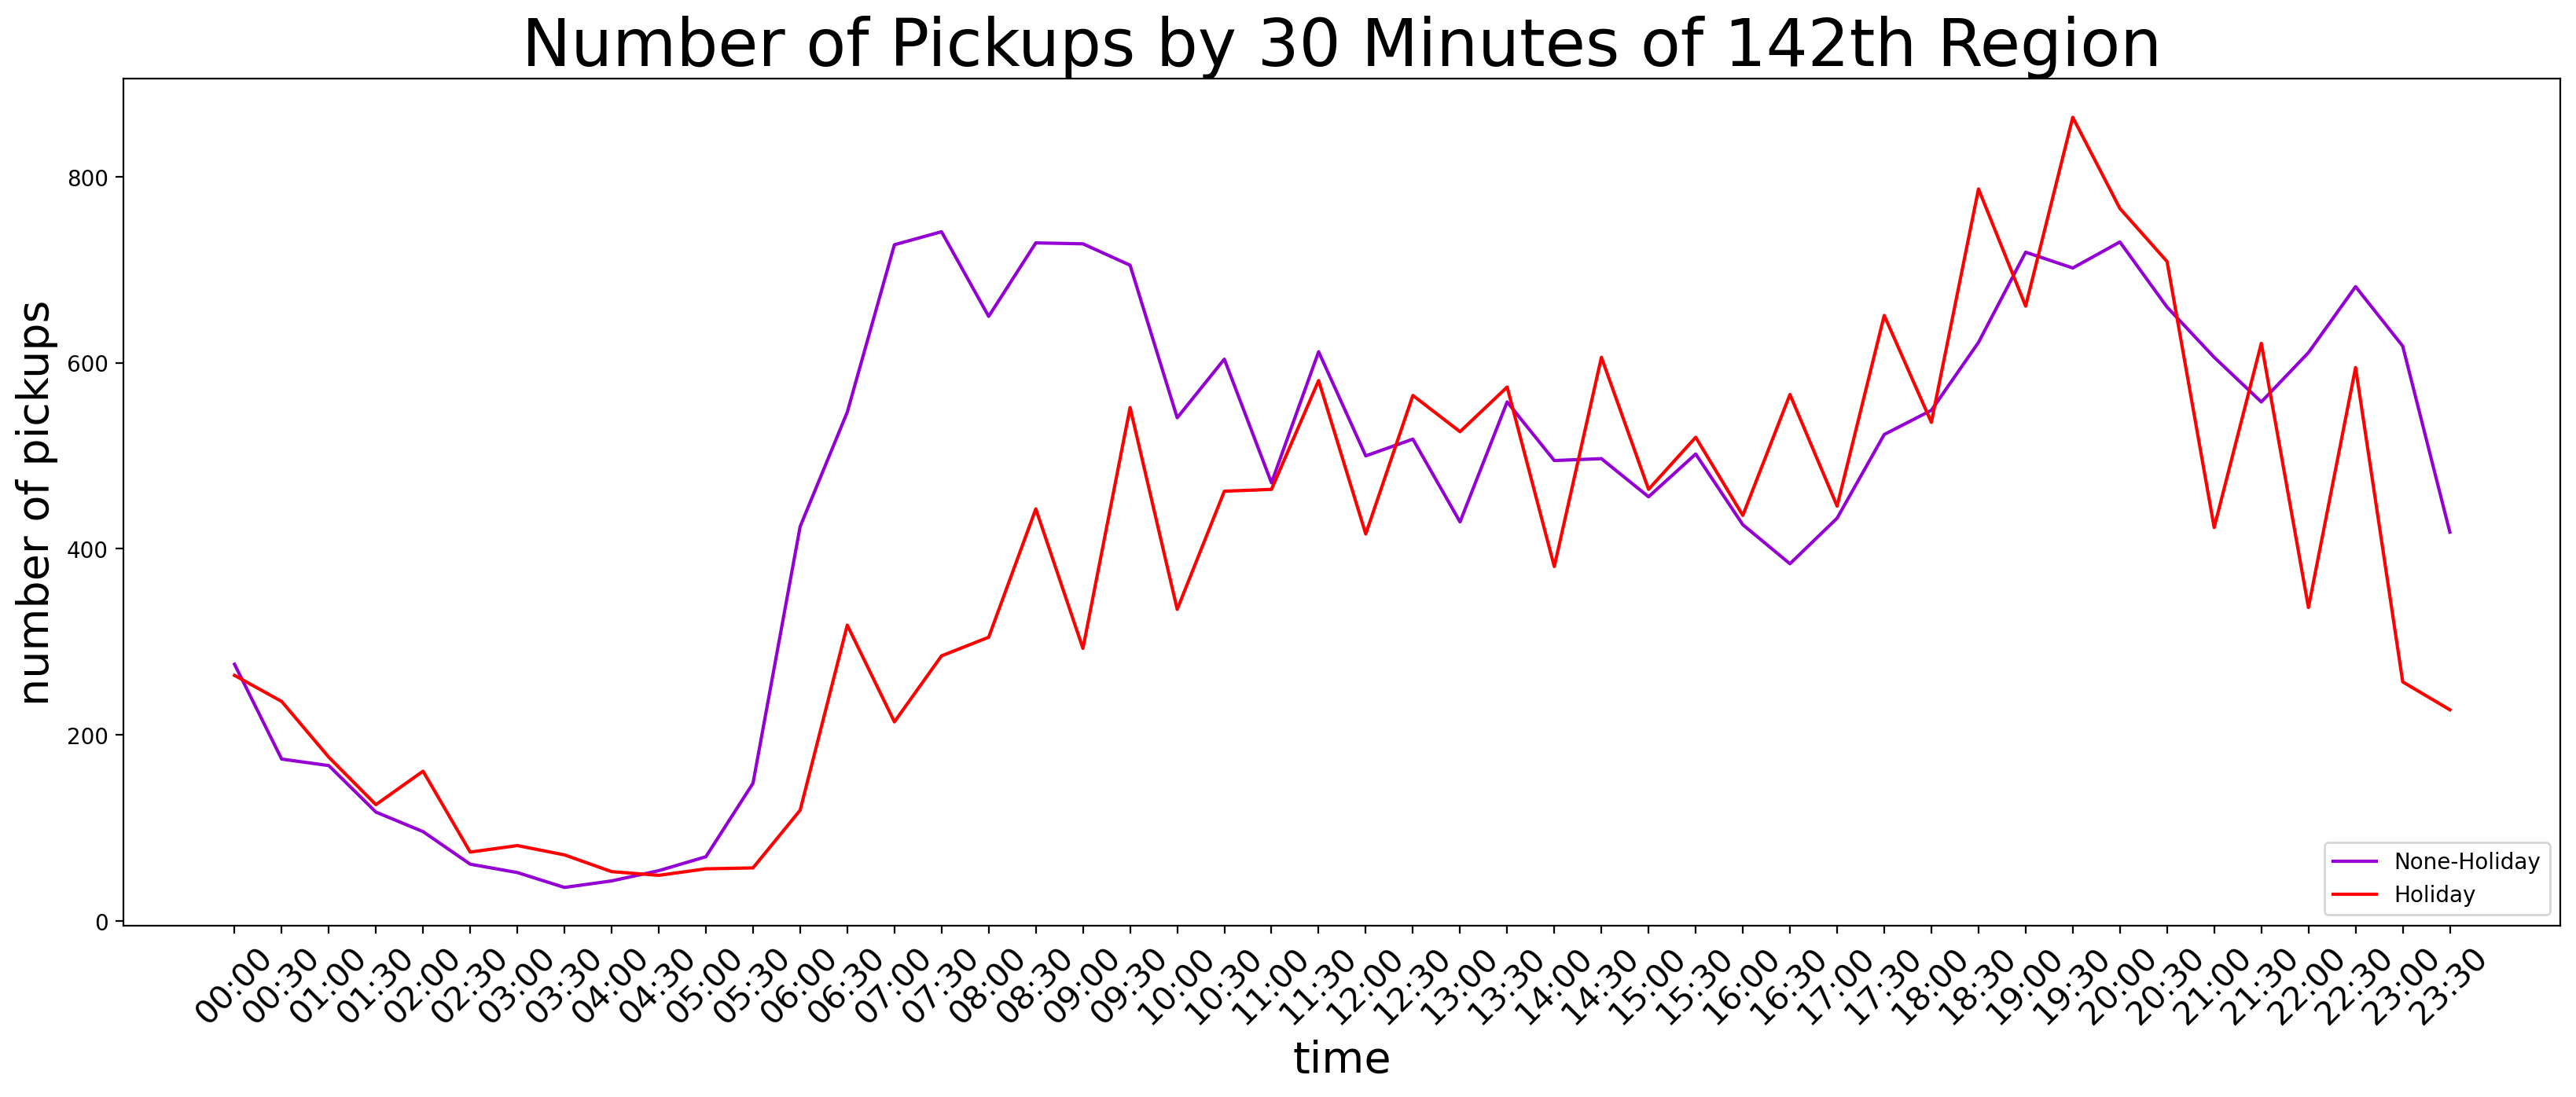

In [75]:
plt.figure(figsize=(20,7))
plt.plot(cls142_0115['datetime3'], cls142_0115['Pickup'], color='darkviolet', label='None-Holiday')
plt.plot(cls142_0119['datetime3'], cls142_0119['Pickup'], color='red', label='Holiday')
plt.xticks(rotation=45, fontsize=15)
plt.legend(loc='lower right')
plt.xlabel('time', fontdict={'fontsize':20})
plt.ylabel('number of pickups', fontdict={'fontsize':20})
plt.title('Number of Pickups by 30 Minutes of 142th Region', fontdict={'fontsize':30})
plt.show()

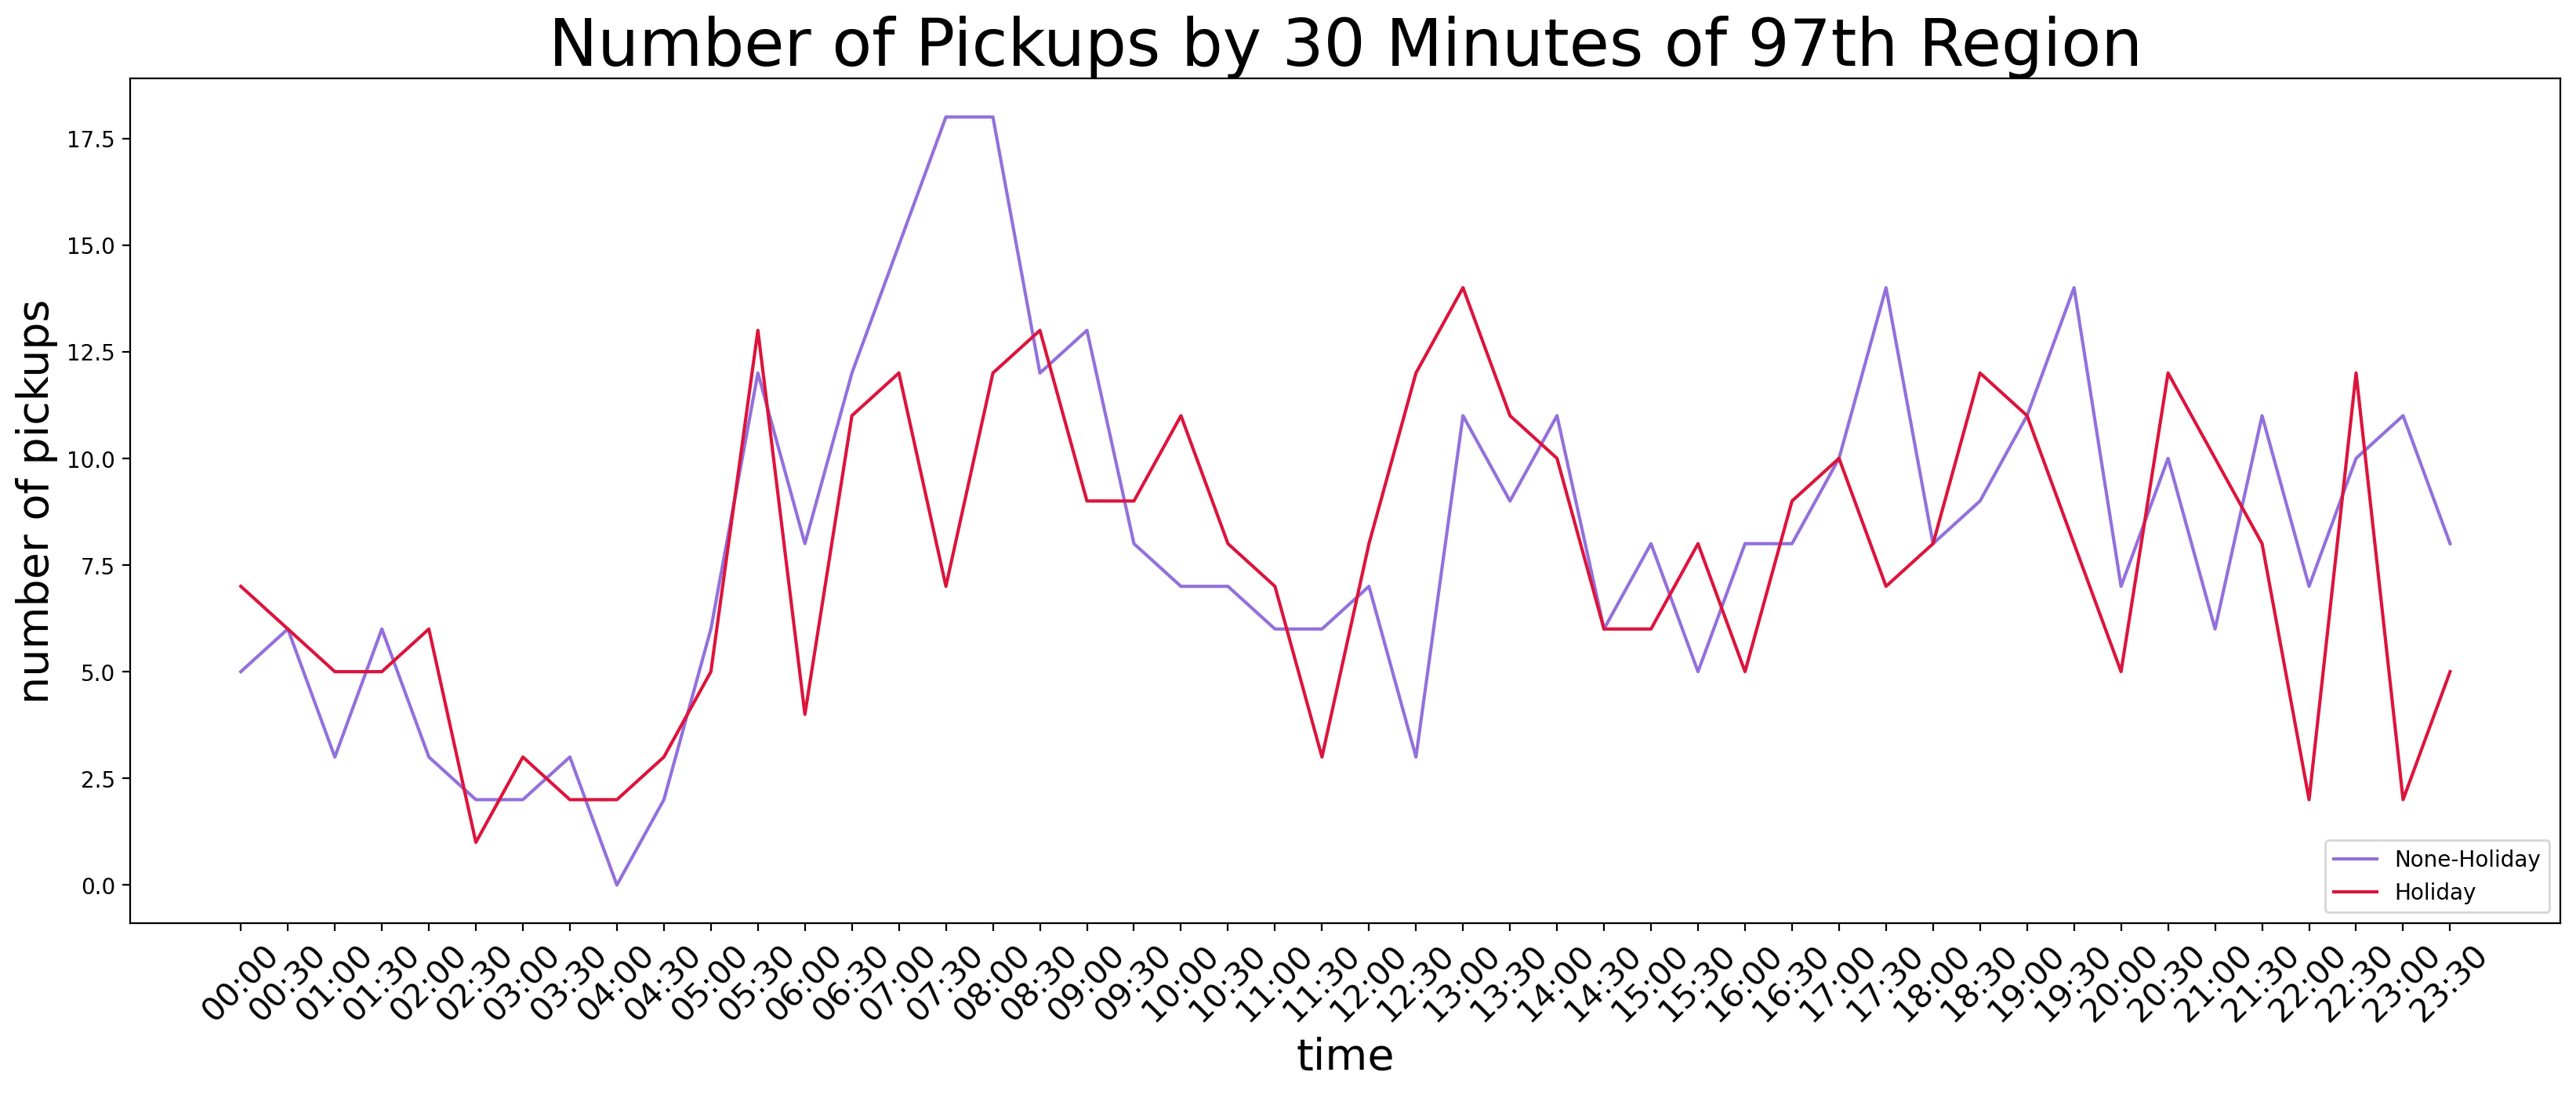

In [76]:
plt.figure(figsize=(20,7))
plt.plot(cls97_0115['datetime3'], cls97_0115['Pickup'], color='mediumpurple', label='None-Holiday')
plt.plot(cls97_0119['datetime3'], cls97_0119['Pickup'], color='crimson', label='Holiday')
plt.xticks(rotation=45, fontsize=15)
plt.legend(loc='lower right')
plt.xlabel('time', fontdict={'fontsize':20})
plt.ylabel('number of pickups', fontdict={'fontsize':20})
plt.title('Number of Pickups by 30 Minutes of 97th Region', fontdict={'fontsize':30})
plt.show()

## (7) 일주일 동안 지역 간 평균 승차 건수 비교

In [77]:
ayofweek1 = eda_train[['datetime', 'Thur', 'Fri', 'Sat', 'Sun', 'Mon','Tue', 'Wed']].groupby(pd.Grouper(key='datetime', freq='D')).mean().reset_index()

In [78]:
cls142 = eda_train2[eda_train2['Clust'] == 142].reset_index().drop('index', axis=1)
cls97 = eda_train2[eda_train2['Clust'] == 97].reset_index().drop('index', axis=1)

In [79]:
dayofweek142 = cls142[['datetime', 'Thur', 'Fri', 'Sat', 'Sun', 'Mon','Tue', 'Wed']].groupby(pd.Grouper(key='datetime', freq='D')).mean().reset_index()
dayofweek97 = cls97[['datetime', 'Thur', 'Fri', 'Sat', 'Sun', 'Mon','Tue', 'Wed']].groupby(pd.Grouper(key='datetime', freq='D')).mean().reset_index()

In [80]:
data142 = cls142[['datetime', 'Pickup', 'Dropoff']].groupby(pd.Grouper(key='datetime', freq='D')).mean().reset_index()
data97 = cls97[['datetime', 'Pickup', 'Dropoff']].groupby(pd.Grouper(key='datetime', freq='D')).mean().reset_index()

In [81]:
dayofweek142 = pd.merge(data142, dayofweek142, left_on='datetime', right_on='datetime', how='inner')
dayofweek97 = pd.merge(data97, dayofweek97, left_on='datetime', right_on='datetime', how='inner')

In [82]:
dayofweek142['dayofweek'] = 0
for i in range(len(dayofweek142)):
    if dayofweek142.iloc[i, 3] == 1:
        dayofweek142.iloc[i, 10] = 'Thursday'
    elif dayofweek142.iloc[i, 4] == 1:
        dayofweek142.iloc[i, 10] = 'Friday'
    elif dayofweek142.iloc[i, 5] == 1:
        dayofweek142.iloc[i, 10] = 'Saturday'
    elif dayofweek142.iloc[i, 6] == 1:
        dayofweek142.iloc[i, 10] = 'Sunday'
    elif dayofweek142.iloc[i, 7] == 1:
        dayofweek142.iloc[i, 10] = 'Monday'
    elif dayofweek142.iloc[i, 8] == 1:
        dayofweek142.iloc[i, 10] = 'Tuesday'
    elif dayofweek142.iloc[i, 9] == 1:
        dayofweek142.iloc[i, 10] = 'Wednesday'

In [83]:
dayofweek97['dayofweek'] = 0
for i in range(len(dayofweek97)):
    if dayofweek97.iloc[i, 3] == 1:
        dayofweek97.iloc[i, 10] = 'Thursday'
    elif dayofweek97.iloc[i, 4] == 1:
        dayofweek97.iloc[i, 10] = 'Friday'
    elif dayofweek97.iloc[i, 5] == 1:
        dayofweek97.iloc[i, 10] = 'Saturday'
    elif dayofweek97.iloc[i, 6] == 1:
        dayofweek97.iloc[i, 10] = 'Sunday'
    elif dayofweek97.iloc[i, 7] == 1:
        dayofweek97.iloc[i, 10] = 'Monday'
    elif dayofweek97.iloc[i, 8] == 1:
        dayofweek97.iloc[i, 10] = 'Tuesday'
    elif dayofweek97.iloc[i, 9] == 1:
        dayofweek97.iloc[i, 10] = 'Wednesday'

In [84]:
pickup142 = dayofweek142[['Pickup', 'dayofweek']].groupby('dayofweek').mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()
pickup97 = dayofweek97[['Pickup', 'dayofweek']].groupby('dayofweek').mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()

Text(0.5, 1.0, 'Number of Pickups by Day of the Week of 142th Region')

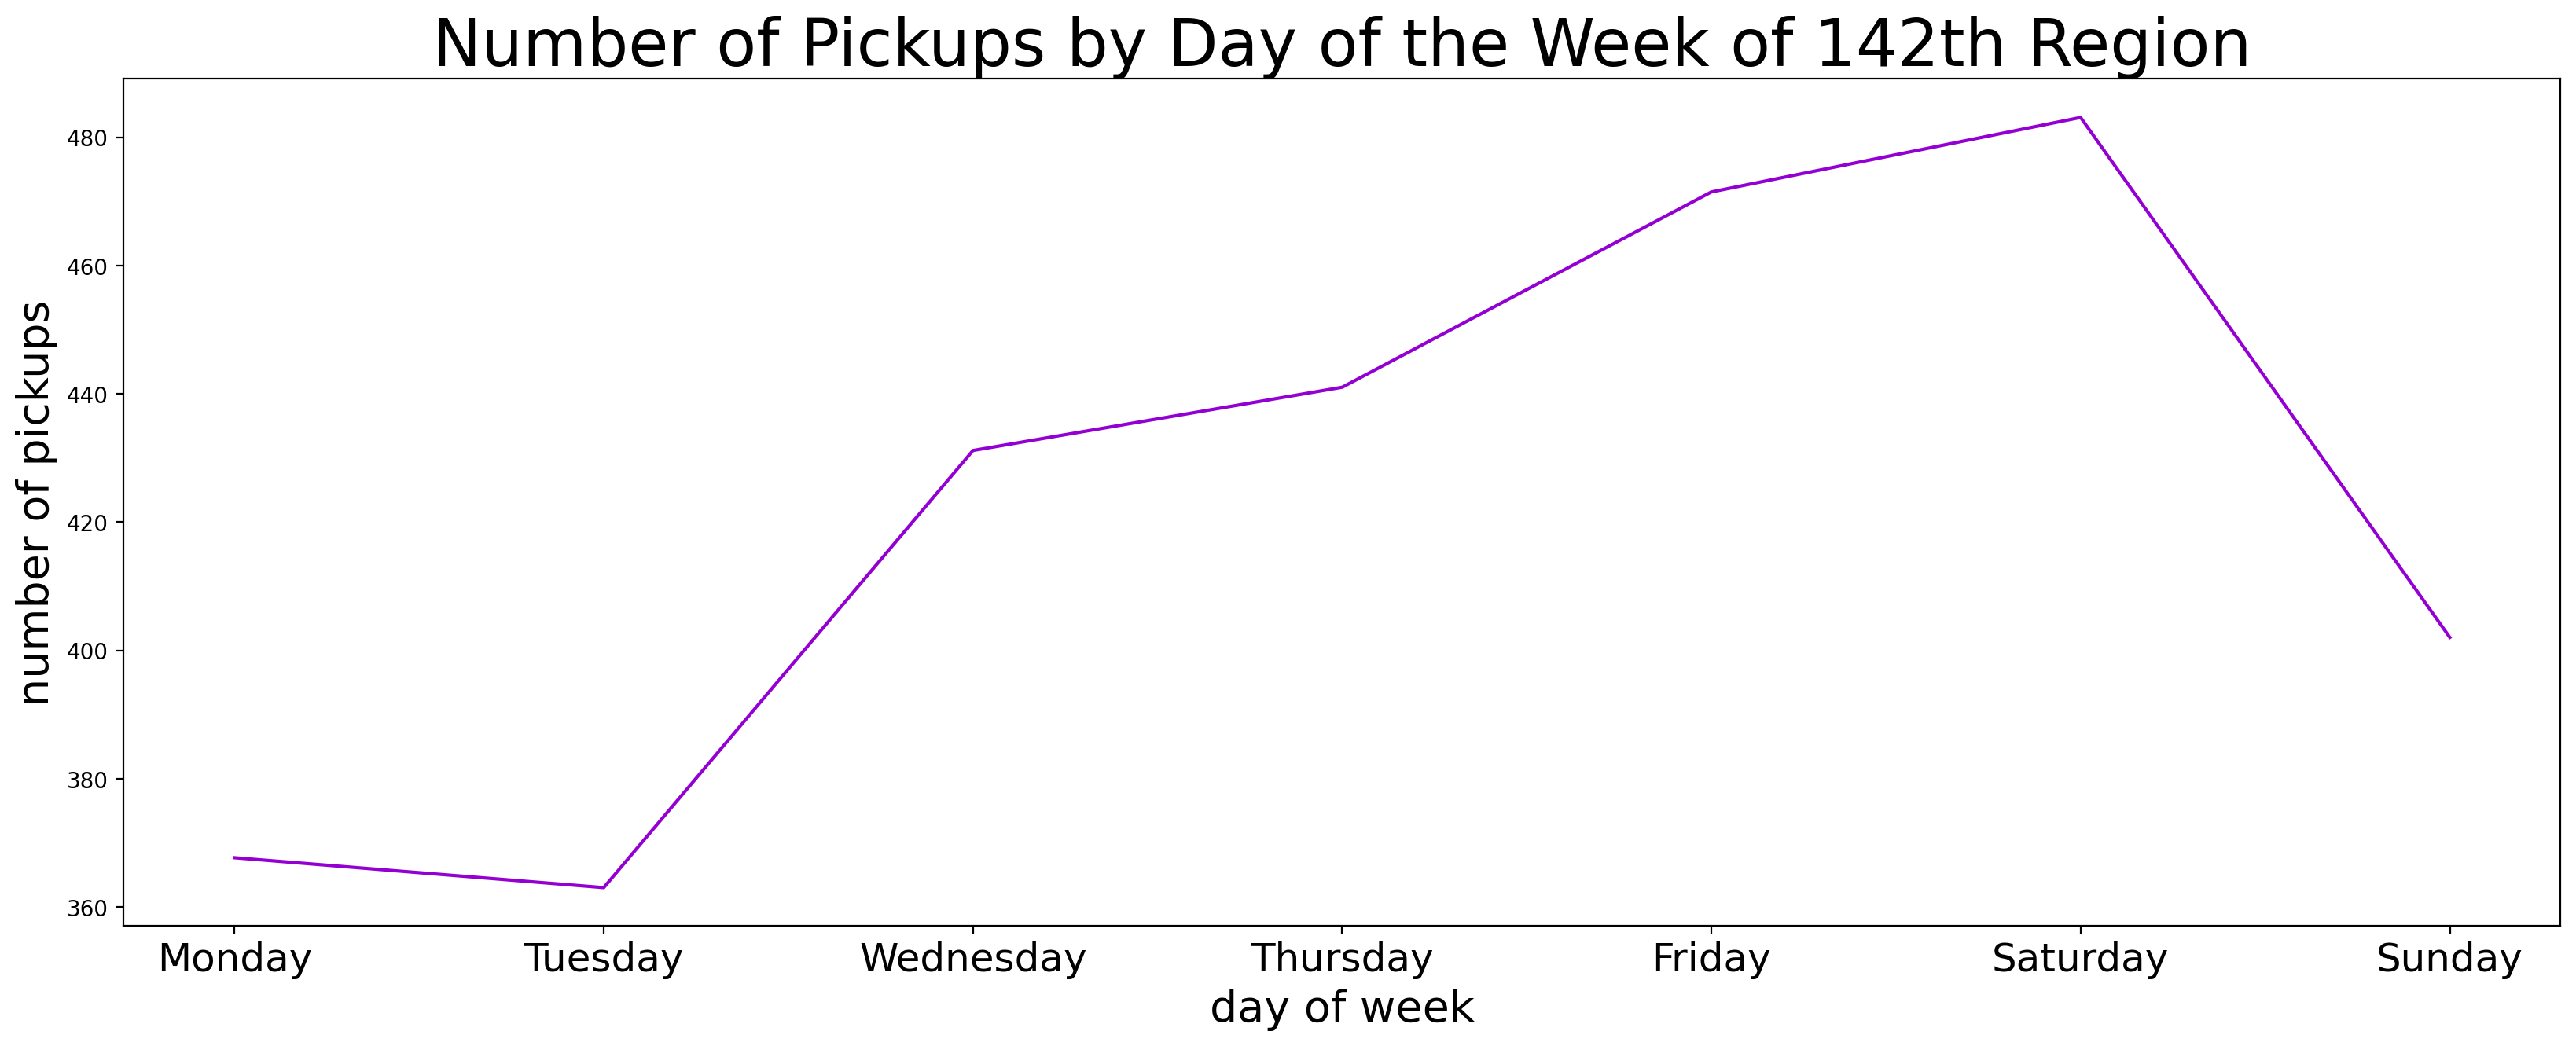

In [85]:
plt.figure(figsize=(20,7))
plt.plot(pickup142["dayofweek"], pickup142["Pickup"], color='darkviolet')
plt.xticks(fontsize=18)
plt.xlabel('day of week', fontdict={'fontsize':20})
plt.ylabel('number of pickups', fontdict={'fontsize':20})
plt.title('Number of Pickups by Day of the Week of 142th Region', fontdict={'fontsize':30})

Text(0.5, 1.0, 'Number of Pickups by Day of the Week of 97th Region')

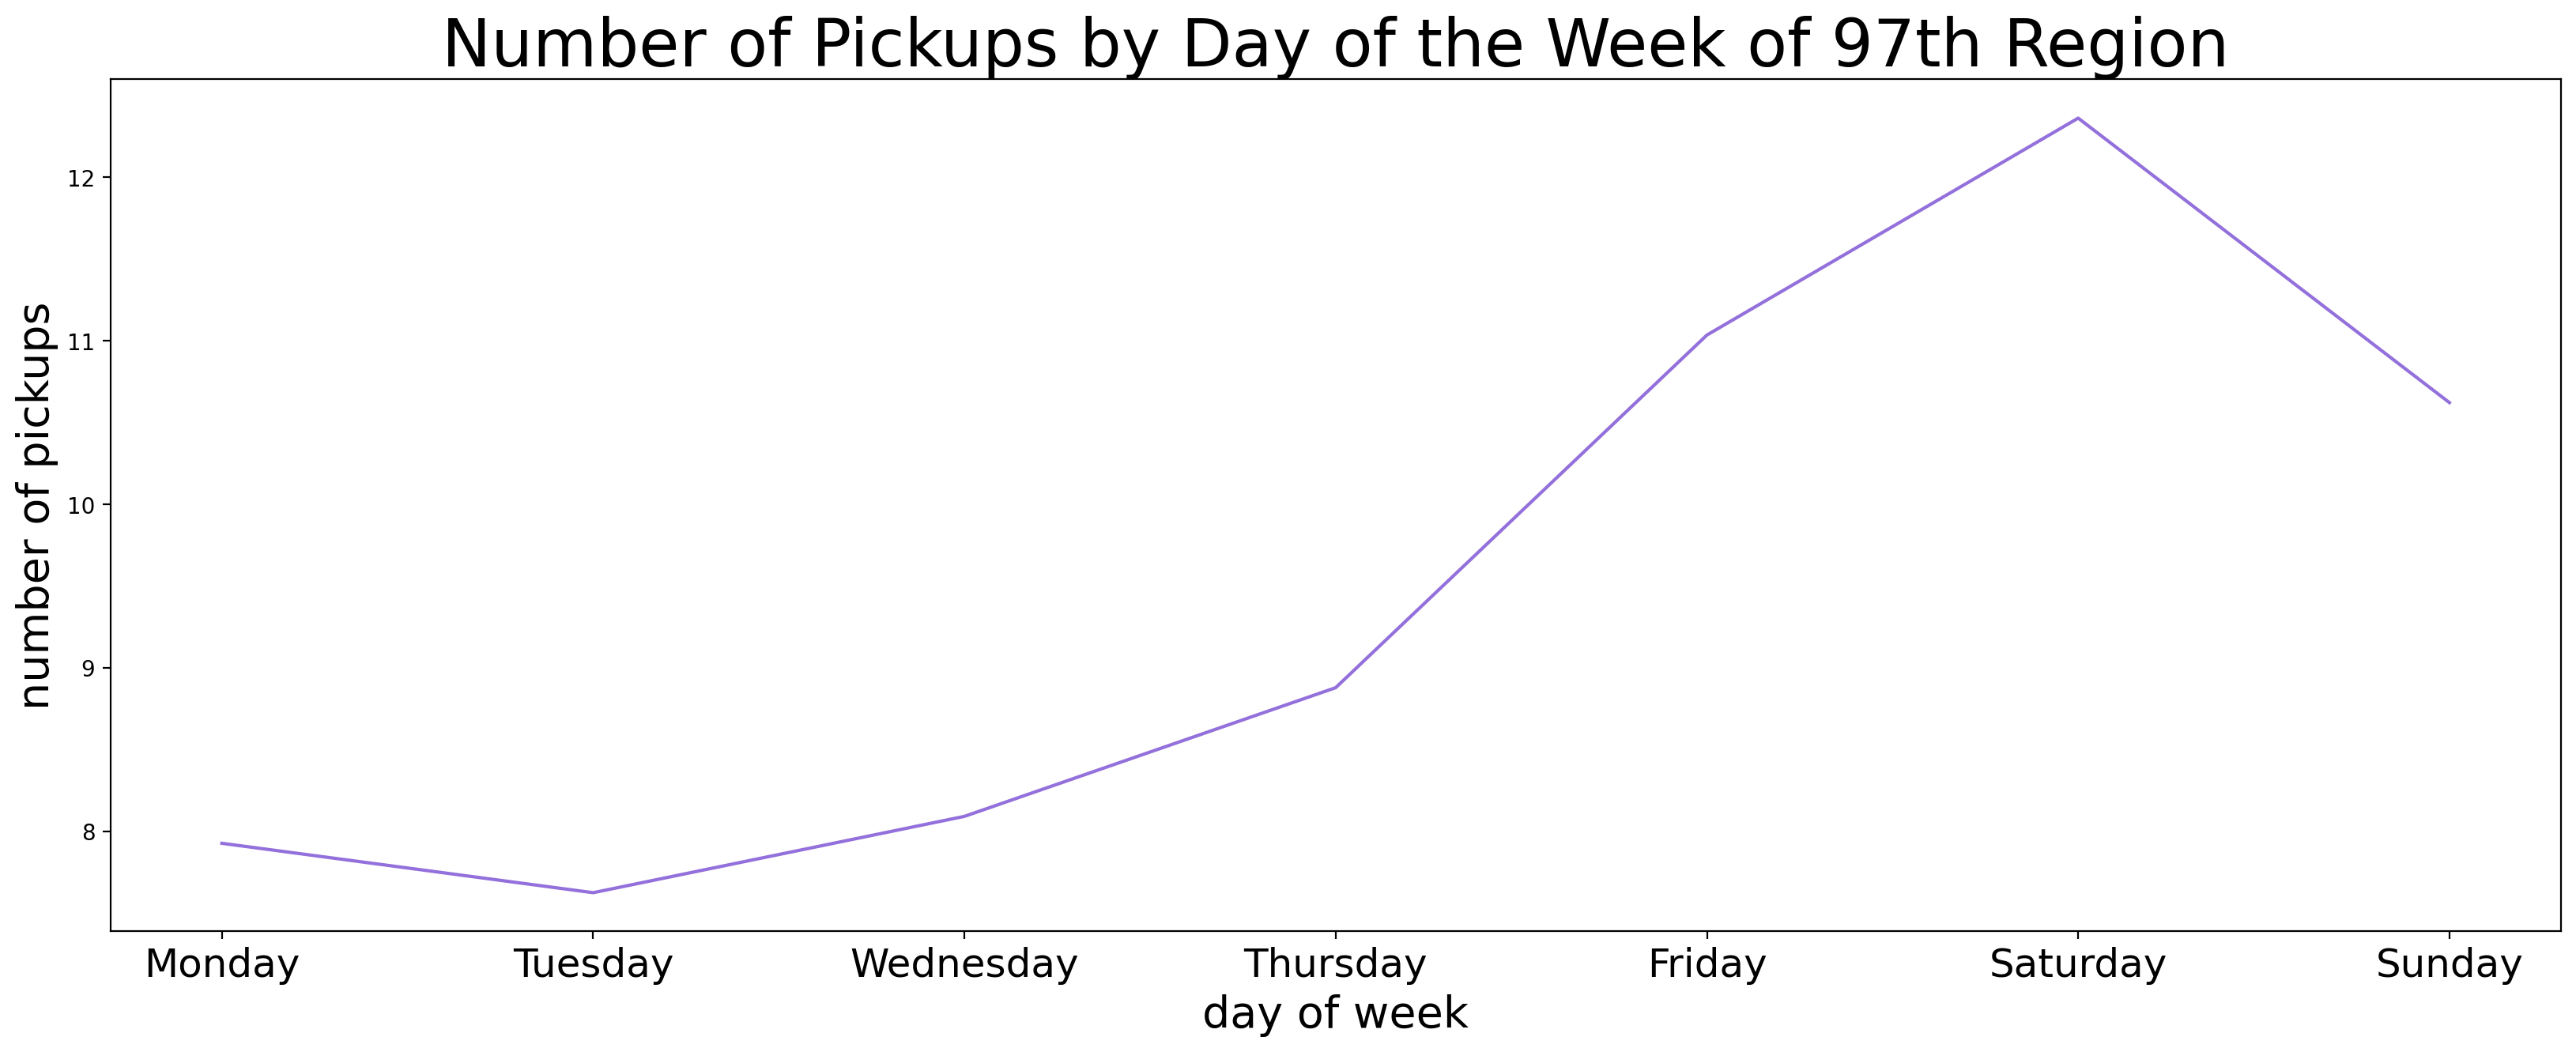

In [86]:
plt.figure(figsize=(20,7))
plt.plot(pickup97["dayofweek"], pickup97["Pickup"], color='mediumpurple')
plt.xticks(fontsize=18)
plt.xlabel('day of week', fontdict={'fontsize':20})
plt.ylabel('number of pickups', fontdict={'fontsize':20})
plt.title('Number of Pickups by Day of the Week of 97th Region', fontdict={'fontsize':30})